# RBP regulome of axonal localization 
**Lisa Fournier, Idiap Research Institute**

**June, 2023**

This notebook is made to investigate the synergistic effects of RBPs in regulating axonal mRNA localisation. In particular, we trained a classifier to distinguish between over- and under-transported 3’ UTR isoforms and analyzed the explainations of the predictions. 

## Table of contents
1. [Load the data](#1-load-the-data)
2. [Define the classification labels](#2-define-the-classification-labels)
3. [Choose a model](#3-choose-a-model)
    1. [Logistic regression](#31-logistic-regression)
    2. [Multilayer Perceptron Classifier (MLP)](#32-multilayer-perceptron-classifier-mlp)
    3. [XGBoost](#33-xgboost)
    4. [Model comparison](#34-model-comparison)
4. [Model 1: All 44 RBPs (M1)](#4-model-1-all-44-rbps-m1)
5. [Model 2: The 33 RBPs positive regulators of localization (M2)](#5-model-2-the-33-rbps-positive-regulators-of-localization-m2)
6. [Model 3: The 11 RBPs negative regulators of localization (M3)](#6-model-3-the-11-rbps-negative-regulators-of-localization-m3)
7. [Model 4: The top 42 nteractions between RBPs (M4)](#7-model-4-the-top-42-interactions-between-rbps-m4)
    1. [Select the top 4 positive and negative RBPs candidate regulators in each condition](#71-select-the-top-4-positive-and-negative-rbps-candidate-regulators-in-each-condition)
    2. [Create pairwise interaction terms](#72-create-pariwise-interaction-terms)
    3. [Train the logistic regression classifier with the interaction terms only](#73-train-the-logistic-regression-classifier-with-the-interaction-terms-only)
8. [Model comparison (M1, M2, M3 & M4)](#8-model-comparison-m1-m2-m3--m4)

In [1]:
## Imports 
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
from gtfparse import read_gtf
from itertools import combinations

## Stats
import statsmodels.formula.api as smf

## plotting
import matplotlib.pyplot as plt
import seaborn as sns

## warnings
import warnings
warnings.filterwarnings('ignore')

## sklearn
import sklearn
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

## Scripts
sys.path.insert(1, "/".join(os.getcwd().split('/')[:-1]))
from scripts.ml_utils import *
from scripts.logistic_regression_utils import *

## Shapley values
import shap
from shap import KernelExplainer
logging.getLogger("shap").setLevel(logging.WARNING)

In [2]:
## plotting style
sns.set(font_scale=1.2, style='ticks')

CustomPalette = sns.color_palette(['#81A4D6', '#AE72B0'])
palette = {'transport_ngf': CustomPalette[0],
           'transport_nt3': CustomPalette[1]}

palette_conditions = {'NGF': CustomPalette[0],
           'NT3': CustomPalette[1]}

CustomNGFShades = sns.color_palette(['#A5C7FB', '#81A4D6', '#5D81B1', '#39608E', '#0F416B', '#00244B', '#729AD2', '#4F7AAF'])
CustomNT3Shades = sns.color_palette(['#FFE4FF', '#AE72B0', '#8F5692', '#723A75', '#551F59', '#3A023F', '#3D0043'])


continuous_palette = [CustomNGFShades, CustomNT3Shades]

## 1. Load the data

3' UTR isoform quantification from 8 samples originating from rat neuronal sympathetic cell cultures where the cell body is treated with low dose of NGF and distal axons are either exposed to NGF or NT3. There are a total of 8 samples: cell body versus distal axons in NGF versus NT3 culture condition across 2 technical replicates.

eClip and iClip data generated in human cell lines (HepG2 and Hela cells) were previously mapped to Hg19 human genome; these data were lifted over the Rn5 rat genome. The object `df_cl` is a matrix where rows are 3' UTR isoforms, columns are `transport_ngf` and `transport_nt3` with the localisation score of the 3' UTR isoforms when exposed to NGF and NT3 respectively. The remaining other 44 columns correspond to the 44 RBPs identified as significant regulators of localization using the Welch test (Supplementary Tables S12 and S13). Entries are 0's if no clip events and 1's if evidence of binding in the region [-250:-50] upstream of the polyadenylation site (PAS) of the transcript.

In [3]:
path_to_results = "./Results/"

df_cl = pd.read_csv("./data/cross_link_events.csv", index_col=0)
negative_regulators = pd.read_csv("./data/negative_regulators_axonal_localisation.csv")
negative_regulators = [neg.split('_')[0].upper() 
                       for neg in negative_regulators.Clips.values if type(neg) == str]

negative_regulators.remove('IGF2BP2') # Remove IGFBP2 from the list because in considered as a positive one in K652 cell line

## 2. Define the classification labels

In both cases (NGF and NT3), an isoform is considered to be over-transported (positive class) if it belongs to the 5% of the 3' UTR isoforms with the highest localization scores. On the opposite, an isoform is considered to be under-transported (negative class) if it belongs to the 5% isoforms with the smallest localisations scores. The final dataset in composed of around 2710 3' UTR isoforms.

Then, for each model 80% of the data has been selected for training, while the other 20% has been kept for testing. The training set was further utilized to perform randomized search on hyperparameters, where a cross-validation strategy with 20 folds was employed to assess the performance of the different hyperparameter combinations. 


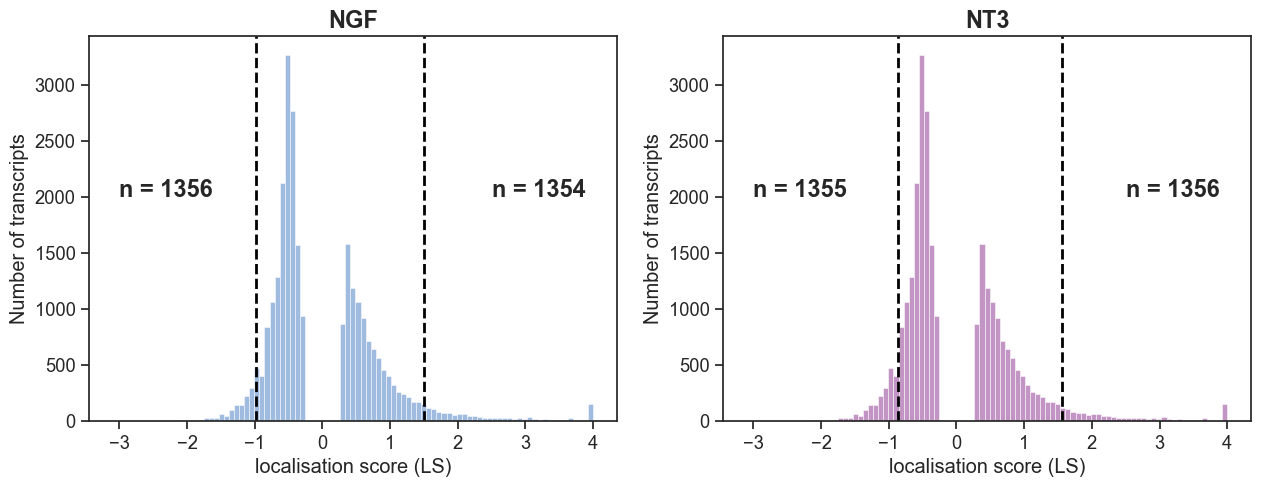

In [4]:
# Define some parameters
conditions_names = ['NGF', 'NT3'] # short-names for the conditions
test_size = 0.2 # size of the testing set
pct_data_to_keep = 0.1 # fraction of the data to keep (the extremes will be kept)


datasets_per_condition = {}
plt.figure(figsize=(15, 5))

for i, condition in enumerate(['transport_ngf', 'transport_nt3']):
    threshold_up = df_cl.sort_values(condition, ascending=False).reset_index().loc[int(np.floor(len(df_cl)*(pct_data_to_keep/2)))][condition]
    threshold_down = df_cl.sort_values(condition).reset_index().loc[int(np.floor(len(df_cl)*(pct_data_to_keep/2)))][condition]
    
    label_name = 'IS_OVERTRANSPORTED_'+conditions_names[i]
    df_condition = set_binary_labels(df_data=df_cl,
                                     col_scores=condition,
                                     threshold_down=threshold_down,
                                     threshold_up=threshold_up,
                                     label_name=label_name).drop(['transport_ngf',
                                                                  'transport_nt3'], axis=1)
    X = df_condition.drop(label_name, axis=1)
    y = df_condition[label_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    

    datasets_per_condition[condition] = {}
    datasets_per_condition[condition]['dataset'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    
    positive_cols = [col for col in X_train.columns if col not in negative_regulators]
    negative_cols = [col for col in X_train.columns if col in negative_regulators]
    
    datasets_per_condition[condition]['dataset_positive'] = {'X_train': X_train[positive_cols], 
                                                             'X_test': X_test[positive_cols],
                                                             'y_train': y_train, 
                                                             'y_test': y_test}
    
    datasets_per_condition[condition]['dataset_negative'] = {'X_train': X_train[negative_cols], 
                                                             'X_test': X_test[negative_cols],
                                                             'y_train': y_train, 
                                                             'y_test': y_test}
    
    plt.subplot(1, 2, i+1)
    sns.histplot(df_cl, x='transport_ngf', color=palette[condition])
    plt.title(condition.split('_')[1].upper(), weight='bold', fontsize=17)
    plt.axvline(x=threshold_down, linestyle='dashed', linewidth=2, color='black')
    plt.axvline(x=threshold_up, linestyle='dashed', linewidth=2, color='black')
    plt.xlabel("localisation score (LS)")
    plt.ylabel("Number of transcripts")
    plt.text(s="n = "+str(len(df_cl[df_cl[condition] < threshold_down])), y=2000, x=-3, fontsize=17, weight='bold')
    plt.text(s="n = "+str(len(df_cl[df_cl[condition] > threshold_up])), y=2000, x=2.5, fontsize=17, weight='bold')                                   

## 3. Choose a model

To solve the classification problem, we tested different models: logistic regression, multilayer perceptron (MLP) and XGBoost. The classification performances of the three different models being very similar (see [section 3.4. Model comparison](#34-model-comparison)) in both NGF and NT3, we decided to use the logistic regression model, as it is the easiest one to interpret.

*__Note__*: *For MLP and XGBoost, the hyperparameters defined here have been optimized through a randomized search that has been run on a computational grid.*

### 3.1 Logistic regression

In [7]:
parameters_lr={'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
               'penalty': ['l2', 'l1', 'elasticnet'],
               'C': [0.01]} # grid-search parameters for logistic regression

In [7]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset',
                              include_plots=False,
                              print_report=False,
                              conditions_names=conditions_names, 
                              palette=palette,
                              step_learning=10, 
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators,                               
                              parameters_lr={'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
                                        'penalty': ['l2', 'l1', 'elasticnet'], 
                                        'C': [0.01]})

Fitting 20 folds for each of 15 candidates, totalling 300 fits
Fitting 20 folds for each of 15 candidates, totalling 300 fits


### 3.2 Multilayer Perceptron Classifier (MLP)

In [9]:
for condition, lr in zip(datasets_per_condition.keys(), ['adaptive', 'constant']):

      X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()

      model = MLPClassifier(solver='sgd', learning_rate_init=0.005, hidden_layer_sizes=(40,), 
                            activation='logistic', learning_rate=lr)
      
      model.fit(X_train, y_train)
      datasets_per_condition[condition]['MLP_model'] = model

### 3.3 XGBoost

In [8]:
for color, condition in zip(['cornflowerblue', 'mediumpurple'], datasets_per_condition.keys()):
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()
    if type(y_train) == pd.DataFrame:
        scale_pos_weight = ((len(y_train) - y_train.sum())/y_train.sum()).values[0]
    else:
        scale_pos_weight = ((len(y_train) - y_train.sum())/y_train.sum())
        
    datasets_per_condition[condition]['XGBoost_model'] = xgb.XGBClassifier(tree_method='approx', enable_categorical=True, 
                                                                           scale_pos_weight=scale_pos_weight, alpha=0.1, n_estimators=500,
                                                                           colsample_bytree=0.5, subsample=0.5, learning_rate=0.001)
    datasets_per_condition[condition]['XGBoost_model'].fit(X_train, y_train, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0);

### 3.4 Model comparison

Text(0.5, 0.98, 'Classification scores for the different models')

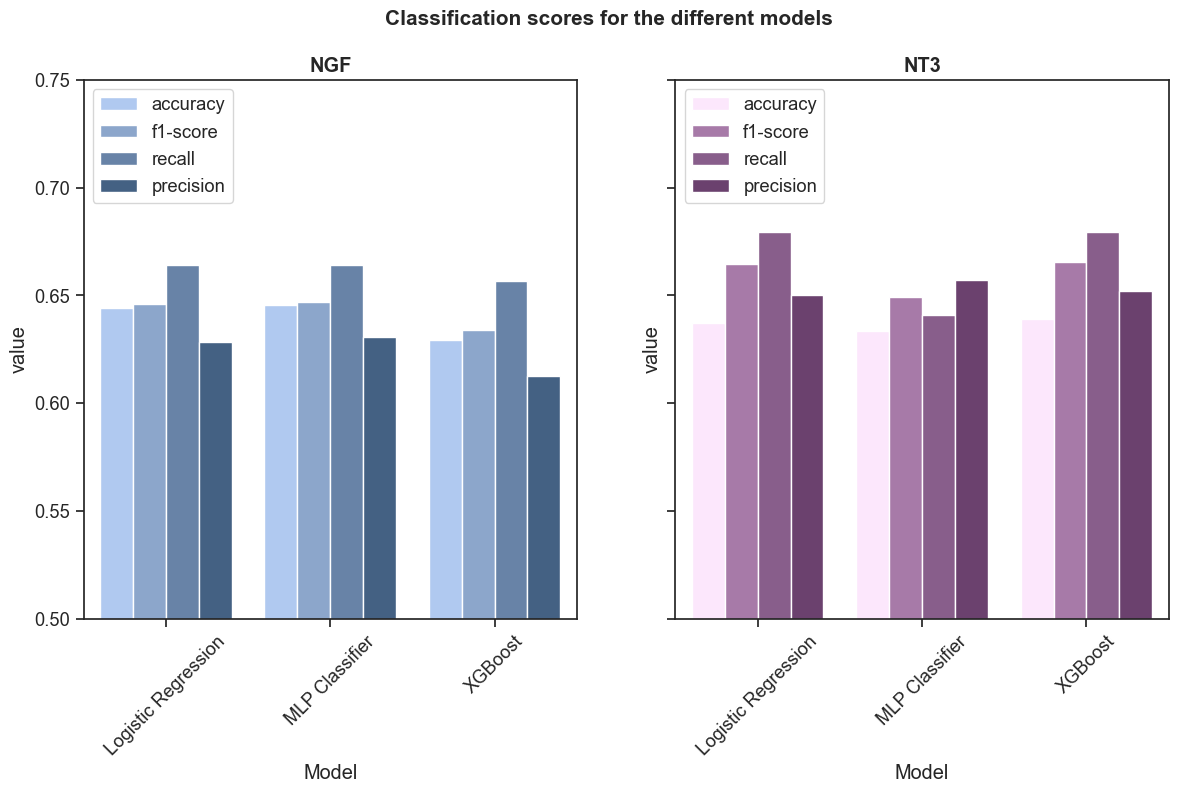

In [10]:
## Plot summarizing the metrics
dfs_summary = {}
for condition in datasets_per_condition.keys():
    
    dfs_summary[condition] = {}
    
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()

    # Logistic regression 
    y_pred = datasets_per_condition[condition]['logit_model'].predict(X_test)
    
    report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    dfs_summary[condition]['Logistic Regression'] = {'accuracy': accuracy, 
                                                                       'f1-score': f1_score, 
                                                                       'recall': recall, 
                                                                       'precision': precision}
    
    # MLP
    y_pred = datasets_per_condition[condition]['MLP_model'].predict(X_test)
    
    report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    dfs_summary[condition]['MLP Classifier'] = {'accuracy': accuracy, 
                                                                       'f1-score': f1_score, 
                                                                       'recall': recall, 
                                                                       'precision': precision}
    
    # XGBoost
    y_pred = datasets_per_condition[condition]['XGBoost_model'].predict(X_test)
    
    report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    dfs_summary[condition]['XGBoost'] = {'accuracy': accuracy, 
                                                                       'f1-score': f1_score, 
                                                                       'recall': recall, 
                                                                       'precision': precision}

fig, ax = plt.subplots(1, len(dfs_summary.keys()), figsize=(7*len(dfs_summary.keys()), 7), sharey=True)

for i, condition in enumerate(dfs_summary.keys()):
    df = pd.DataFrame(dfs_summary[condition])
    scores = list(df.index)
    df_plot = pd.melt(df, var_name='Model')
    df_plot['Score'] = scores*df.shape[1]
    
    sns.barplot(df_plot, x='Model', y='value', hue='Score', ax=ax[i], palette=continuous_palette[i])
    ax[i].legend(loc='upper left')
    ax[i].set_title(conditions_names[i], weight='bold')
    ax[i].set_ylim(0.5, 0.75)
    ax[i].set_xticks(ticks=np.arange(len(dfs_summary[condition].keys())), 
                    labels=dfs_summary[condition].keys(),
                    rotation=45)
plt.suptitle("Classification scores for the different models", weight='bold', fontsize=15)

## 4. Model 1: All 44 RBPs (M1)

Here, we train a logistic regression classifier to discriminate over- from under-transported 3’ UTR isoforms using the full set of 44 candidate positive and negative regulators of axonal localisation. We report the classification results and the coefficients of the logistic regression. 

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       277
           1       0.63      0.66      0.65       265

    accuracy                           0.64       542
   macro avg       0.64      0.64      0.64       542
weighted avg       0.64      0.64      0.64       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       256
           1       0.65      0.68      0.66       287

    accuracy                           0.64       543
   macro avg       0.64      0.63      0.63       543
weighted avg       0.64      0.64      0.64       543



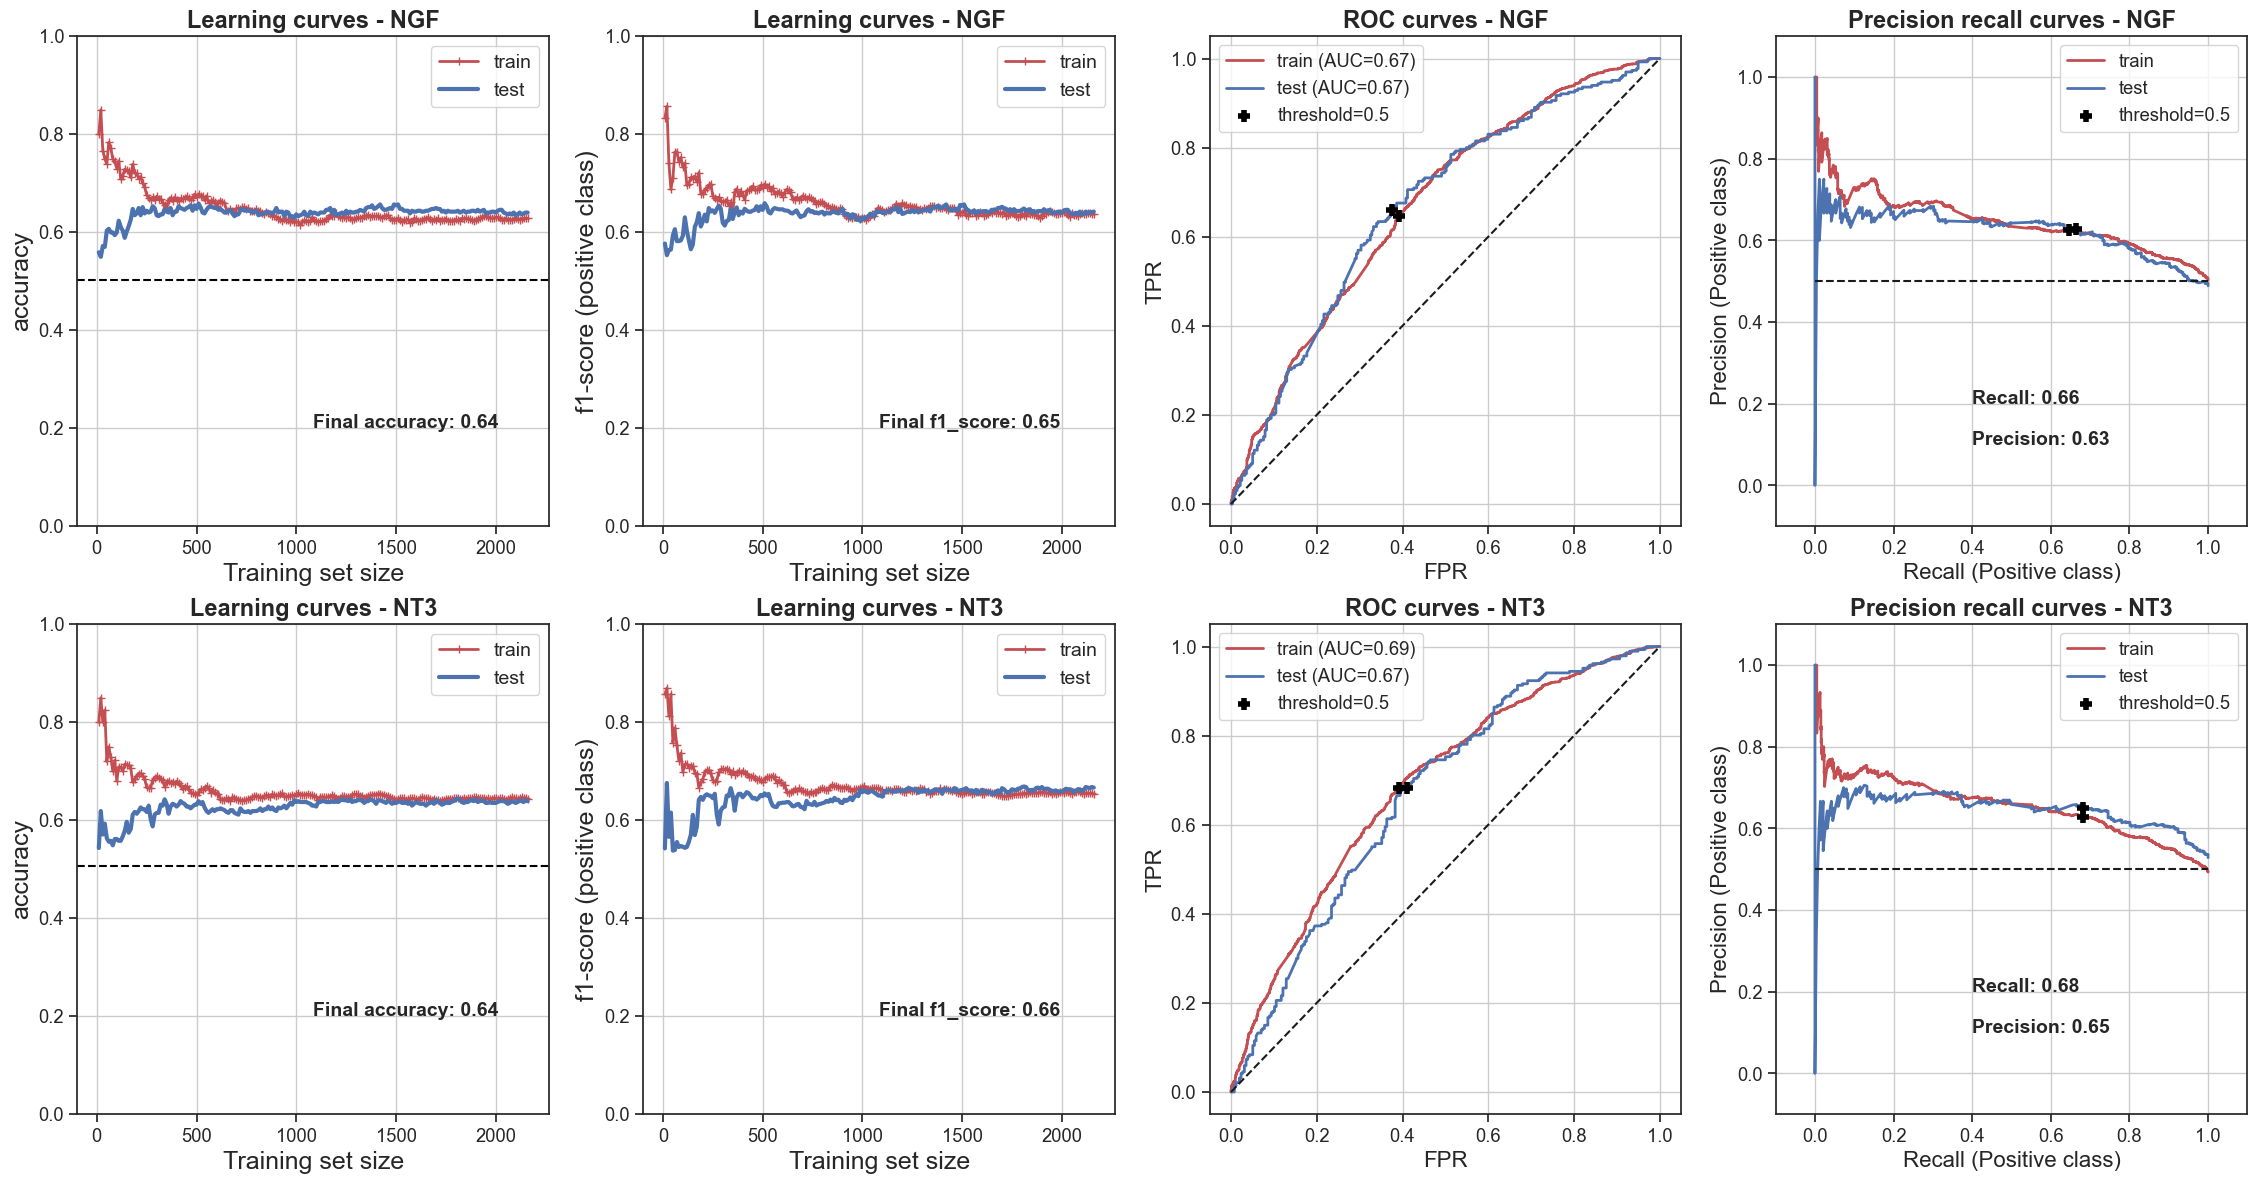

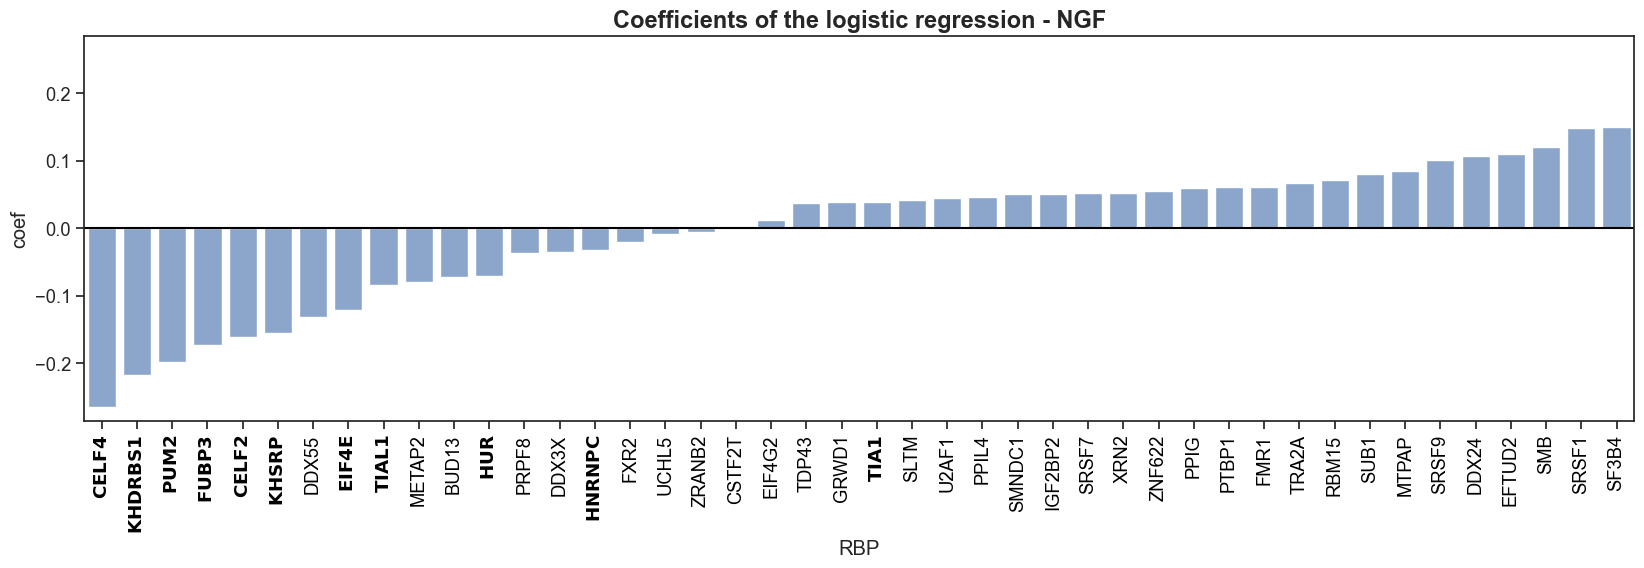

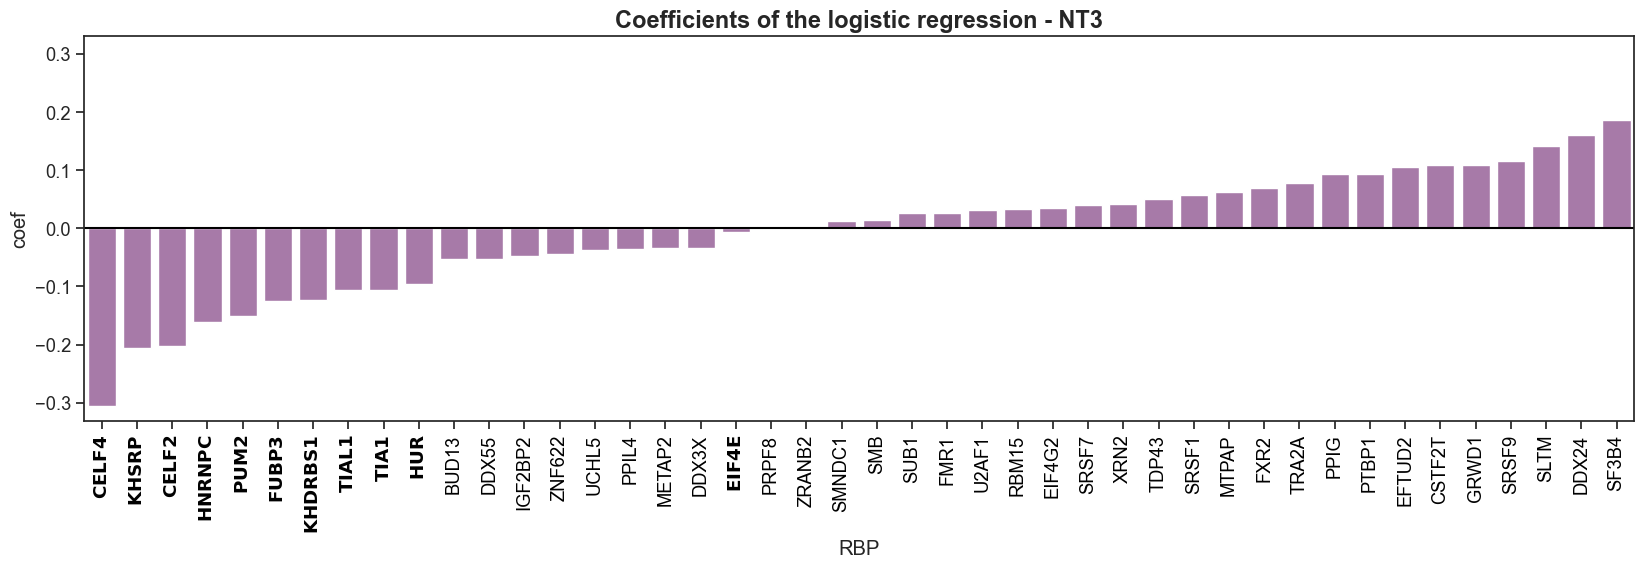

In [8]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset',
                              include_plots=True,
                              conditions_names=conditions_names, 
                              feature_name_col='RBP',
                              palette=palette,
                              step_learning=10,
                              negative_regulators=negative_regulators, 
                              parameters_lr=parameters_lr)

*__Note__*: *The RBPs in **bold** are the regulators identified as negative regulators using the Welch's test.*

To identify the statistically significant predictors in each model (RBPs or interaction of RBPs) in each culture condition, we compared the observed predictor coefficients to their respective null distributions. To generate a null distribution for each predictor, we shuffled the response variable label randomly, re-trained the model and re-calculated the predictor coefficients. We repeated this process 2000 times. To compare the observed predictor coefficients with the null distributions generated, we computed their z-scores as:
$$ z_{predictor} = \frac{x - \mu}{\sigma}$$
where $x$ is the observed predictor coefficient, $\mu$ and $\sigma$ are the mean and standard deviation of the null distribution for this predictor. 

- If $|z_{predictor}| > 1.645$ (95% confidence; one-tailed), then the predictor is a significant regulator of localisation. In particular: 
    - if $z_{predictor} < 0$, the predictor is a negative regulator of localisation.
    - if $z_{predictor} > 0$, the predictor is a positive regulator of localisation.
    
To compare regulators between the NGF and NT3 conditions, we applied the following rules: 
- if a predictor is significant in both the NGF and the NT3 model, then this predictor is a common regulator of localisation. 
- if a predictor is significant in only one of the two models, therefore this predictor is a specific regulator of this model.


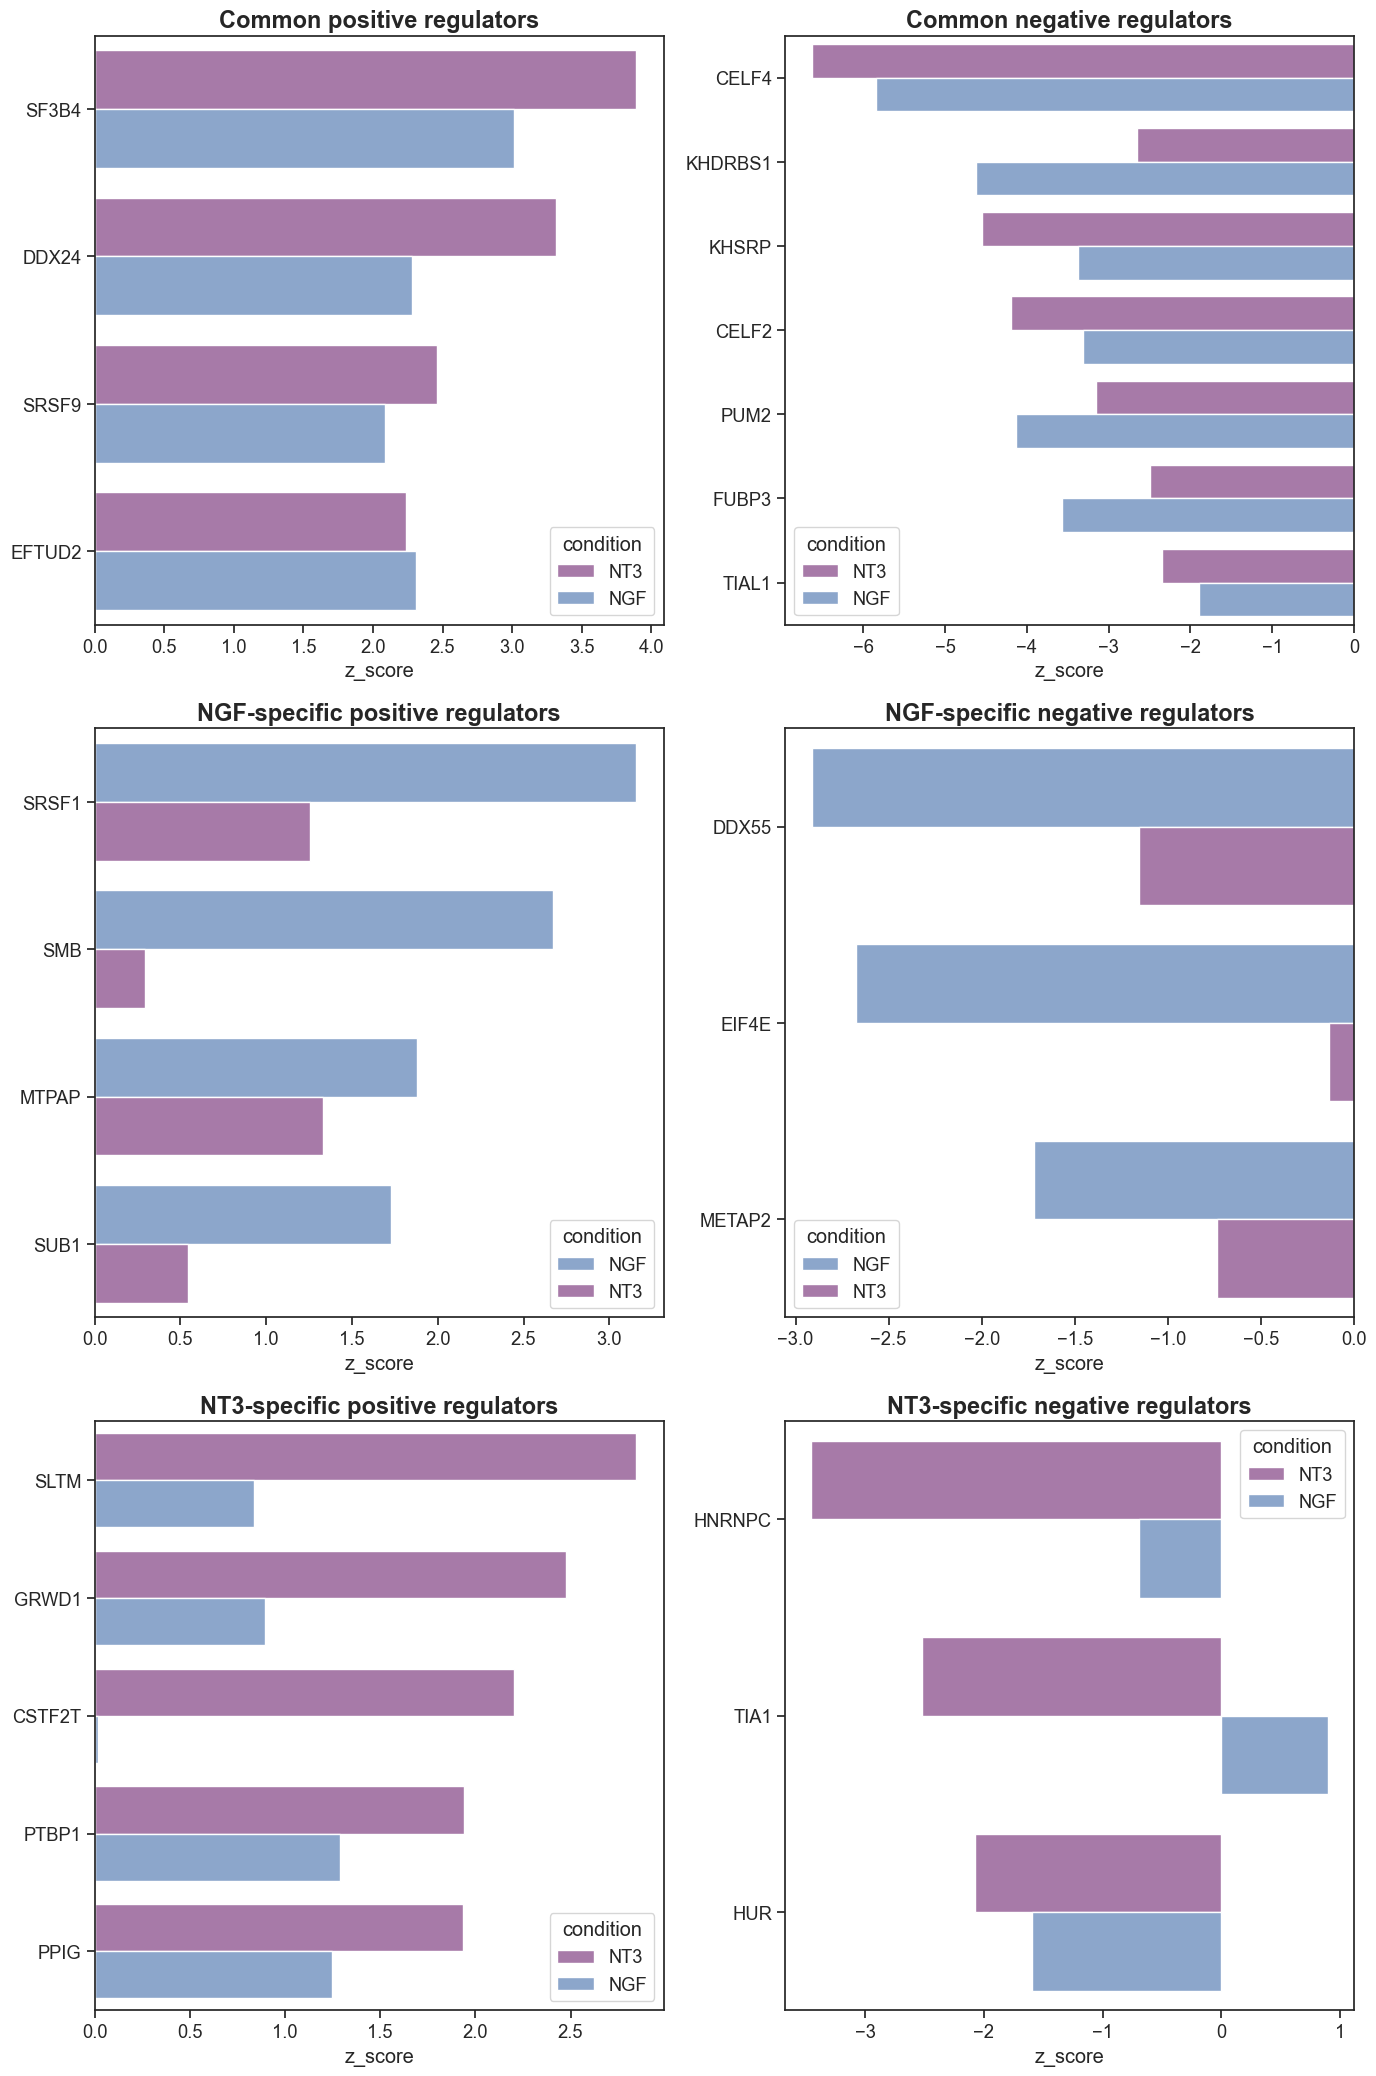

In [12]:
dic_summary = plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset',
                                         model_key='logit_model',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions,
                                         return_groups=True)

For another visualization, we treated the logistic regression classifier as a black box model and computed the Shapley values for a few samples of the testing set. We can observe that the negative and positive regulators identified with the Welch's test are also very well retrieved by the logistic regression classifier.

In [14]:
nb_shapley = 5

100%|██████████| 5/5 [02:20<00:00, 28.13s/it]


100%|██████████| 5/5 [02:14<00:00, 26.85s/it]


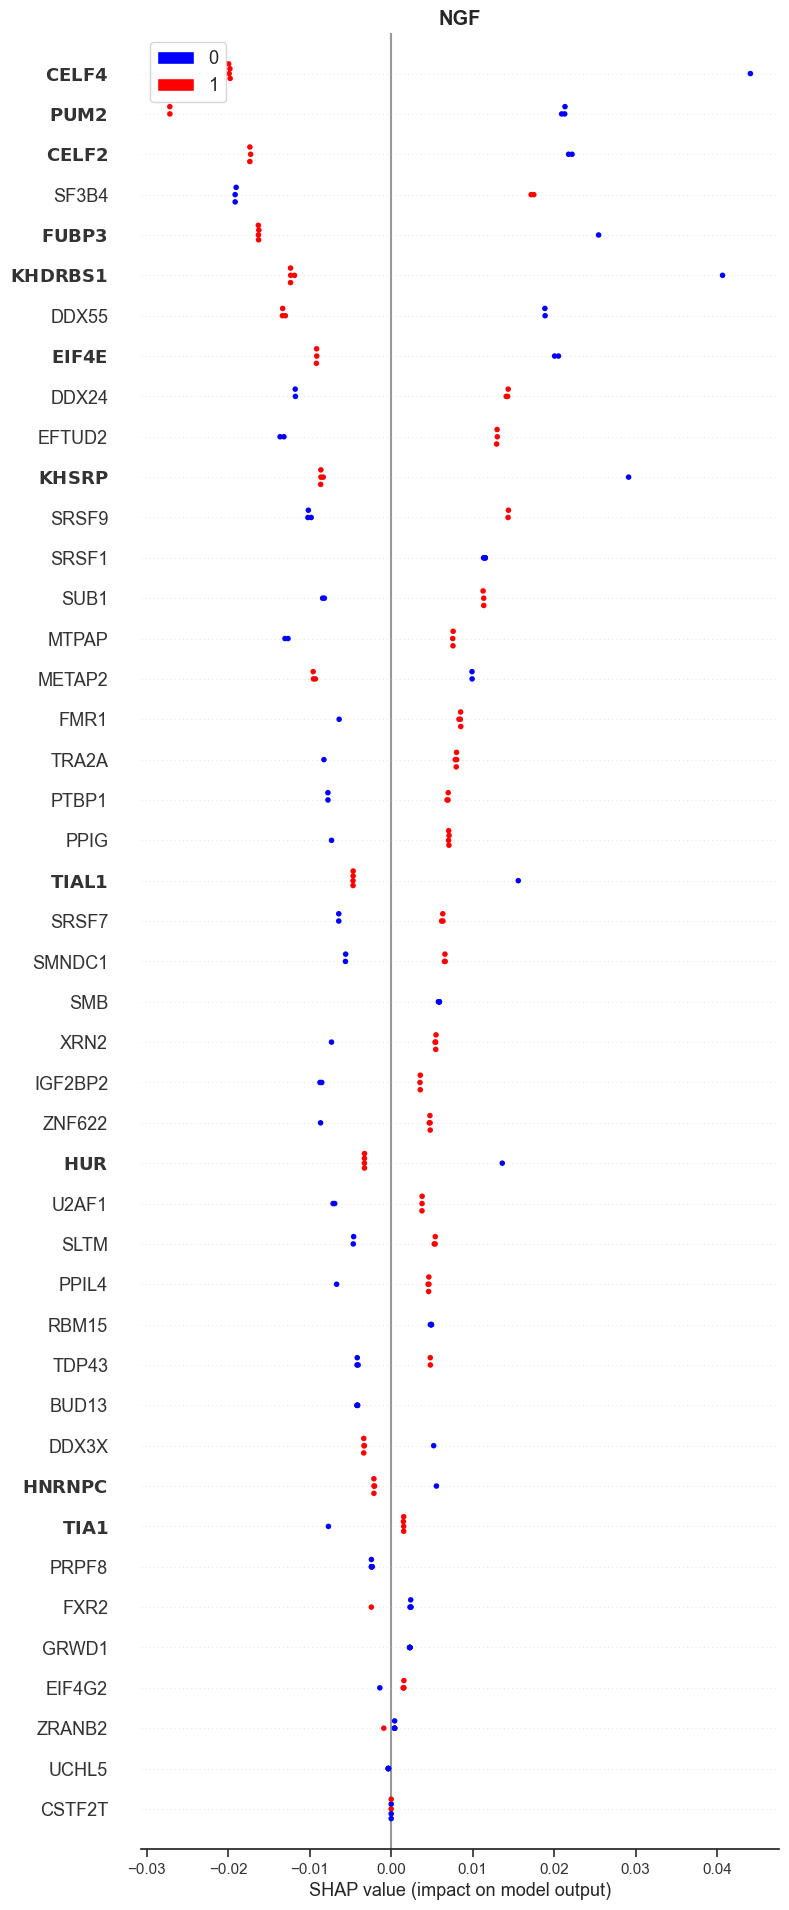

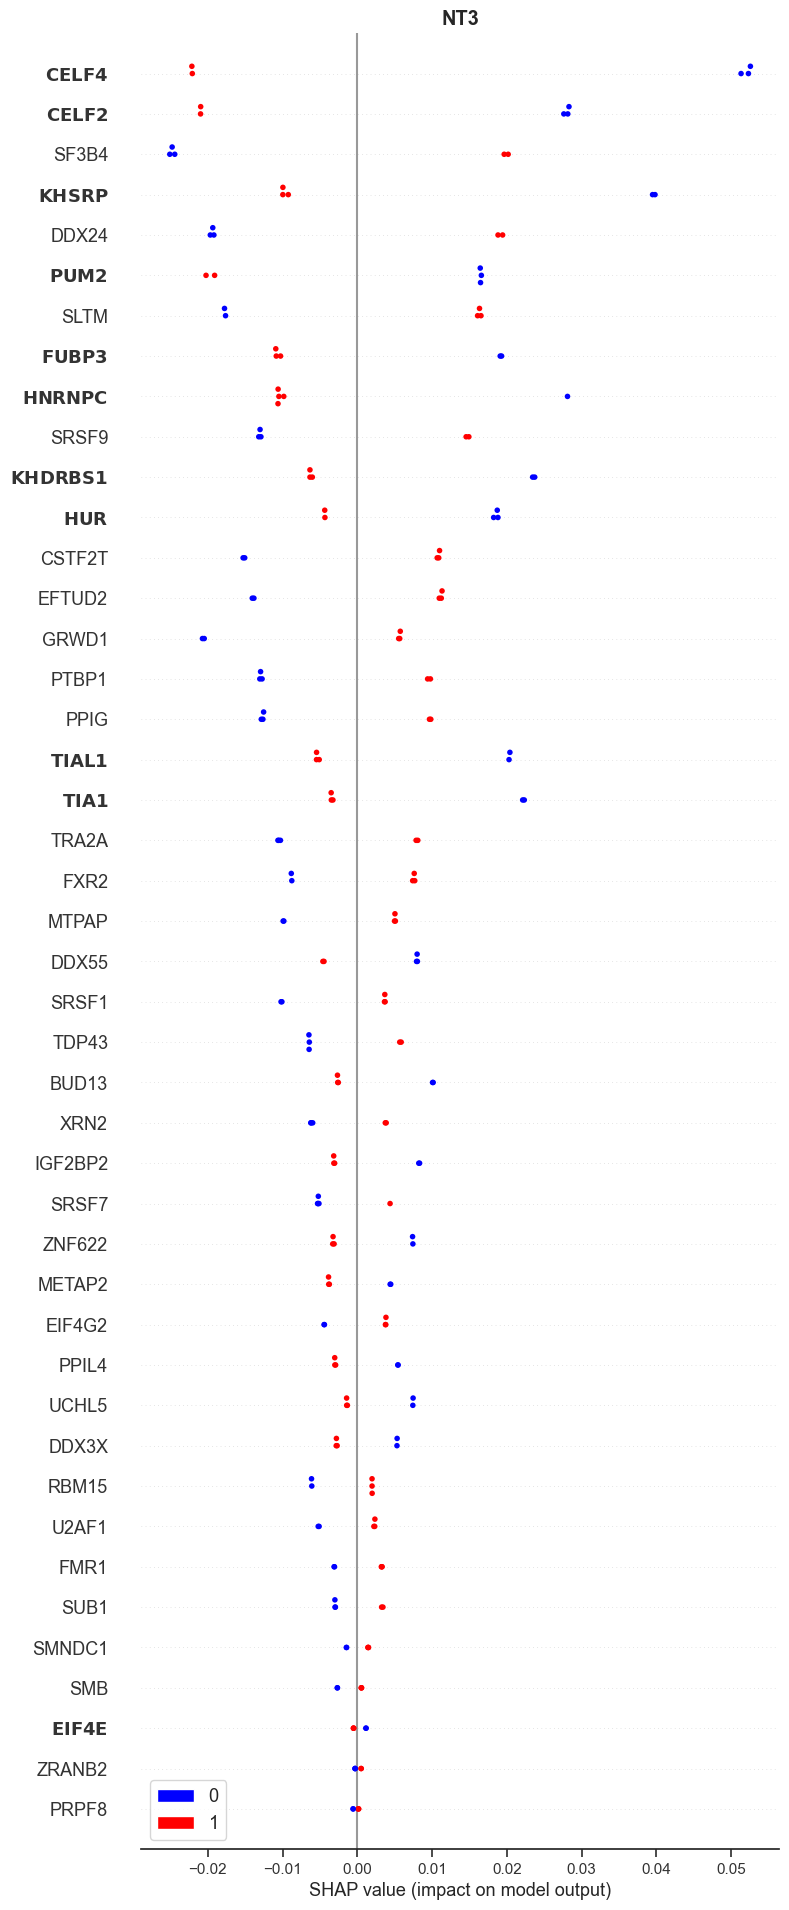

In [15]:
for i, condition in enumerate(datasets_per_condition.keys()):
    model = datasets_per_condition[condition]['logit_model']
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()
    feature_names = datasets_per_condition[condition]['dataset']['X_train'].columns

    shap.initjs()
    
    # Initialize the explainer
    explainer = KernelExplainer(model.predict_proba, X_train, n_jobs=4)
    
    # Compute the shapley values
    shap_values = explainer.shap_values(X_test[:nb_shapley])
    
    plot_shapley(shap_values=shap_values, 
                 X_test=X_test[:nb_shapley], 
                 feature_names=feature_names, 
                 max_display=X_test.shape[1], 
                 show=False,
                 class_label=1,
                 negative_regulators=negative_regulators, 
                 condition_name=conditions_names[i], 
                 beeswarm_only=True)

## 5. Model 2: The 33 RBPs positive regulators of localization (M2)

Here, we train a logistic regression classifier to discriminate over- from under-transported 3’ UTR isoforms using the 33 candidate positive regulators of axonal localisation only. We report the classification results and the coefficients of the logistic regression. To identify the statistically significant predictors in each model (RBPs or interaction of RBPs) in each culture condition, we compared the observed predictor coefficients to their respective null distributions, as described in the section [section 4](#4-model-1-all-44-rbps-m1).

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.58      0.63      0.60       277
           1       0.57      0.52      0.54       265

    accuracy                           0.57       542
   macro avg       0.57      0.57      0.57       542
weighted avg       0.57      0.57      0.57       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.52      0.59      0.56       256
           1       0.59      0.52      0.55       287

    accuracy                           0.55       543
   macro avg       0.56      0.56      0.55       543
weighted avg       0.56      0.55      0.55       543



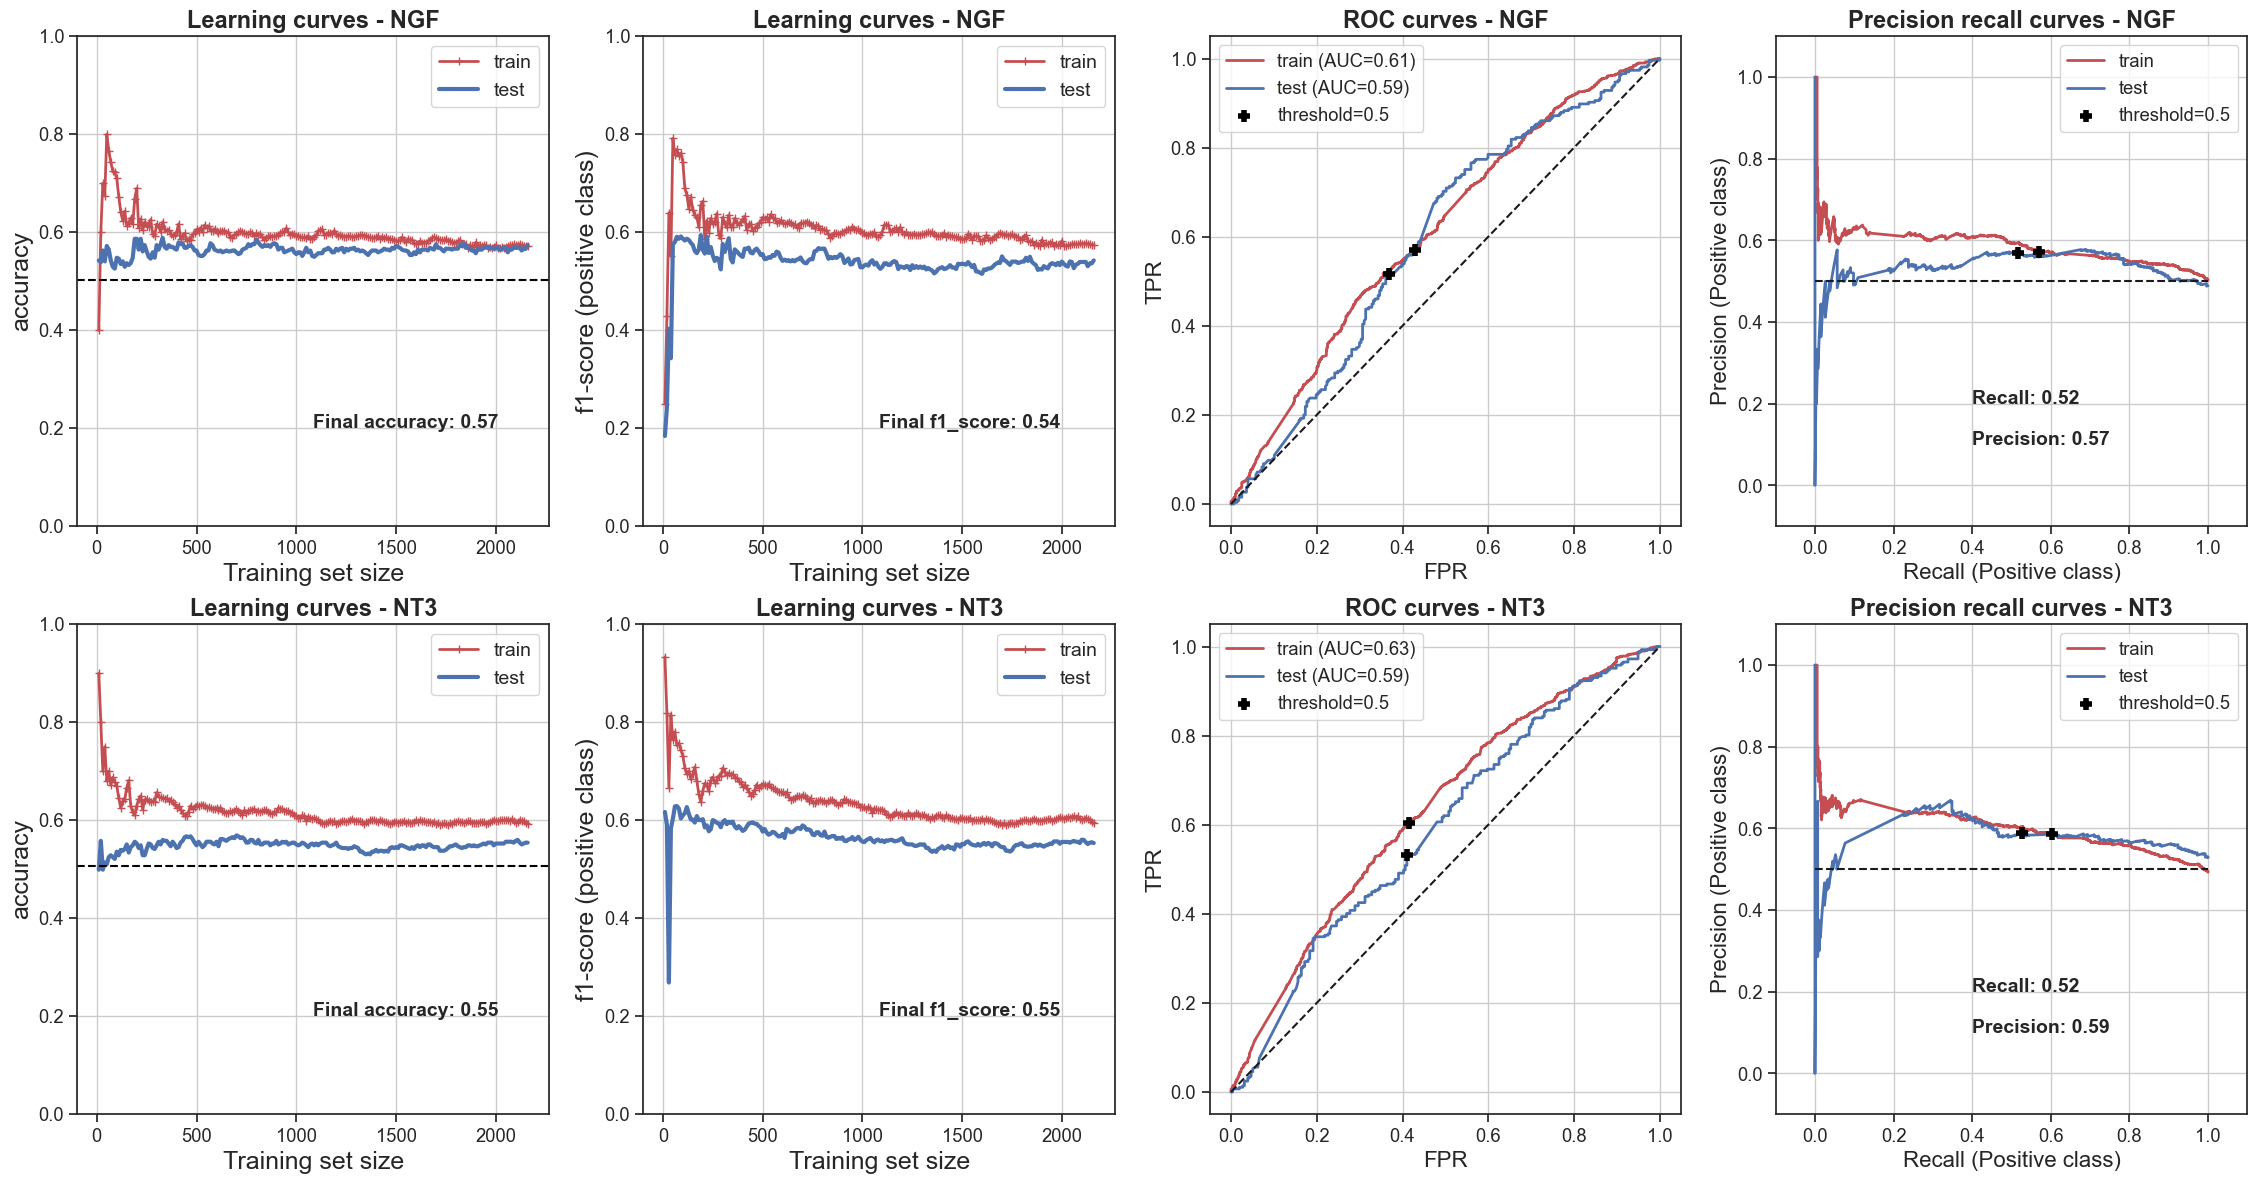

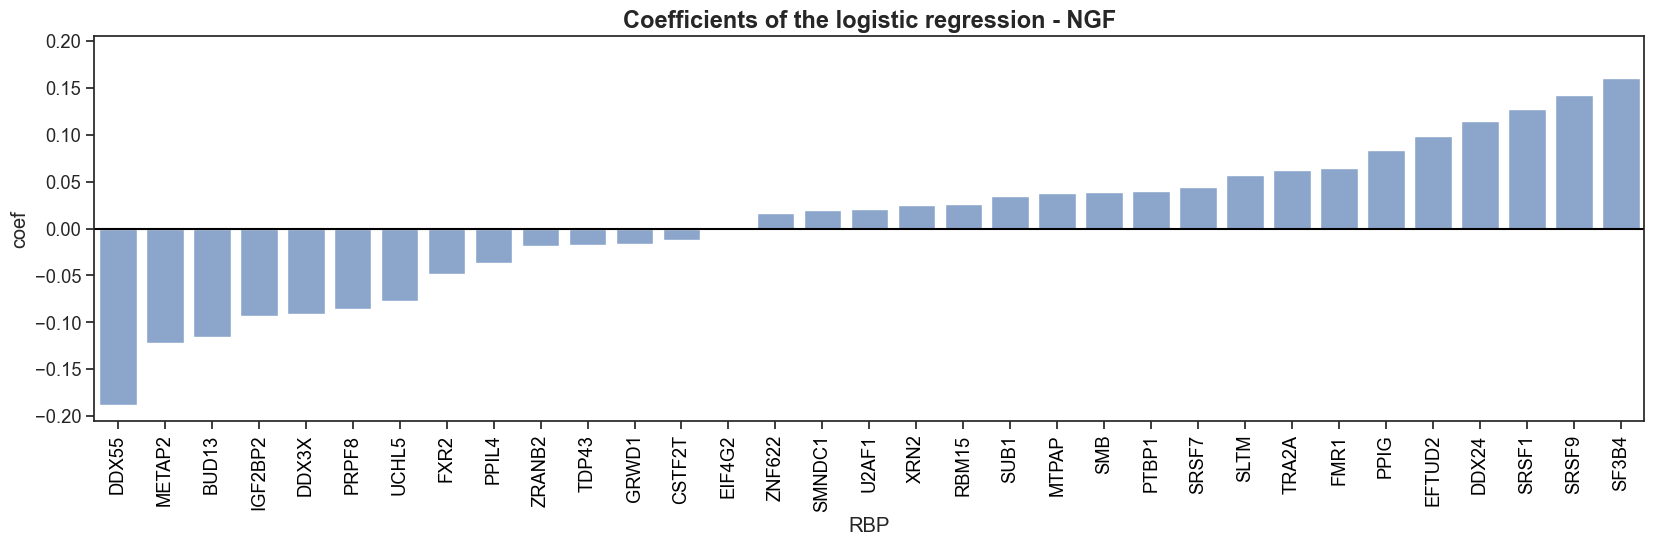

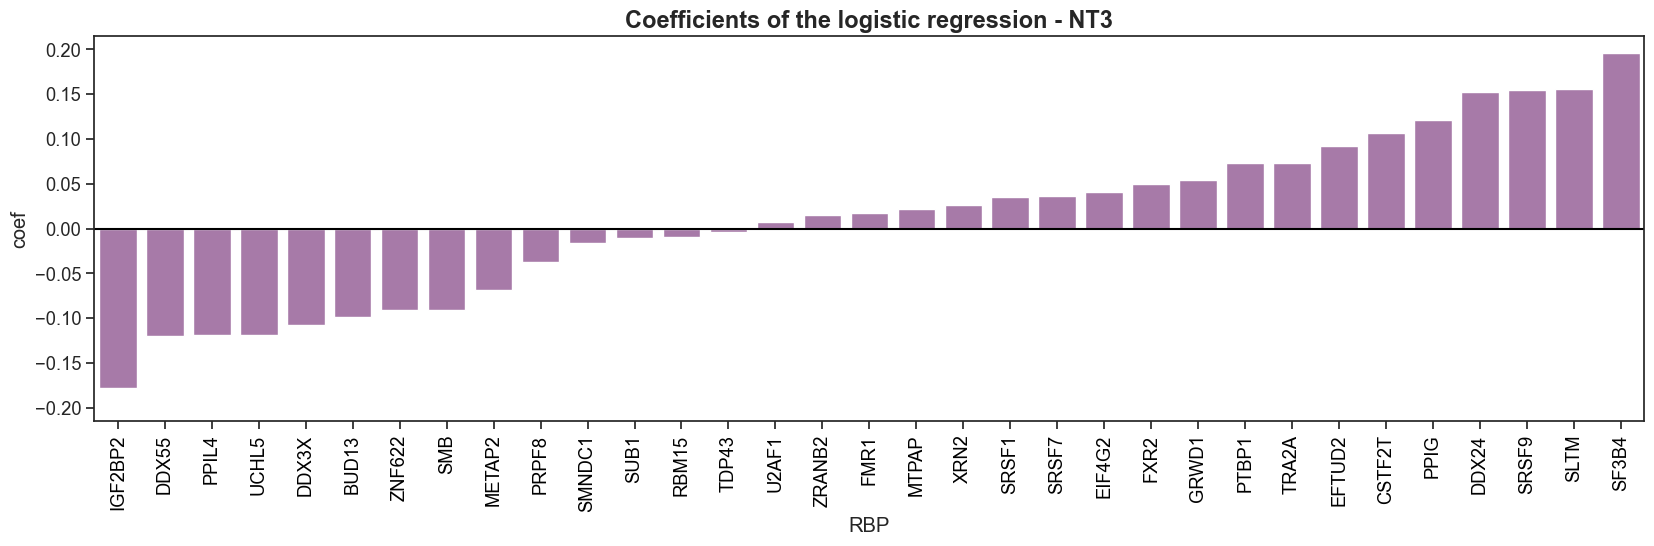

In [14]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset_positive',
                              suffix='_positive',
                              include_plots=True,
                              conditions_names=conditions_names, 
                              palette=palette,
                              step_learning=10,
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators, 
                              parameters_lr=parameters_lr)

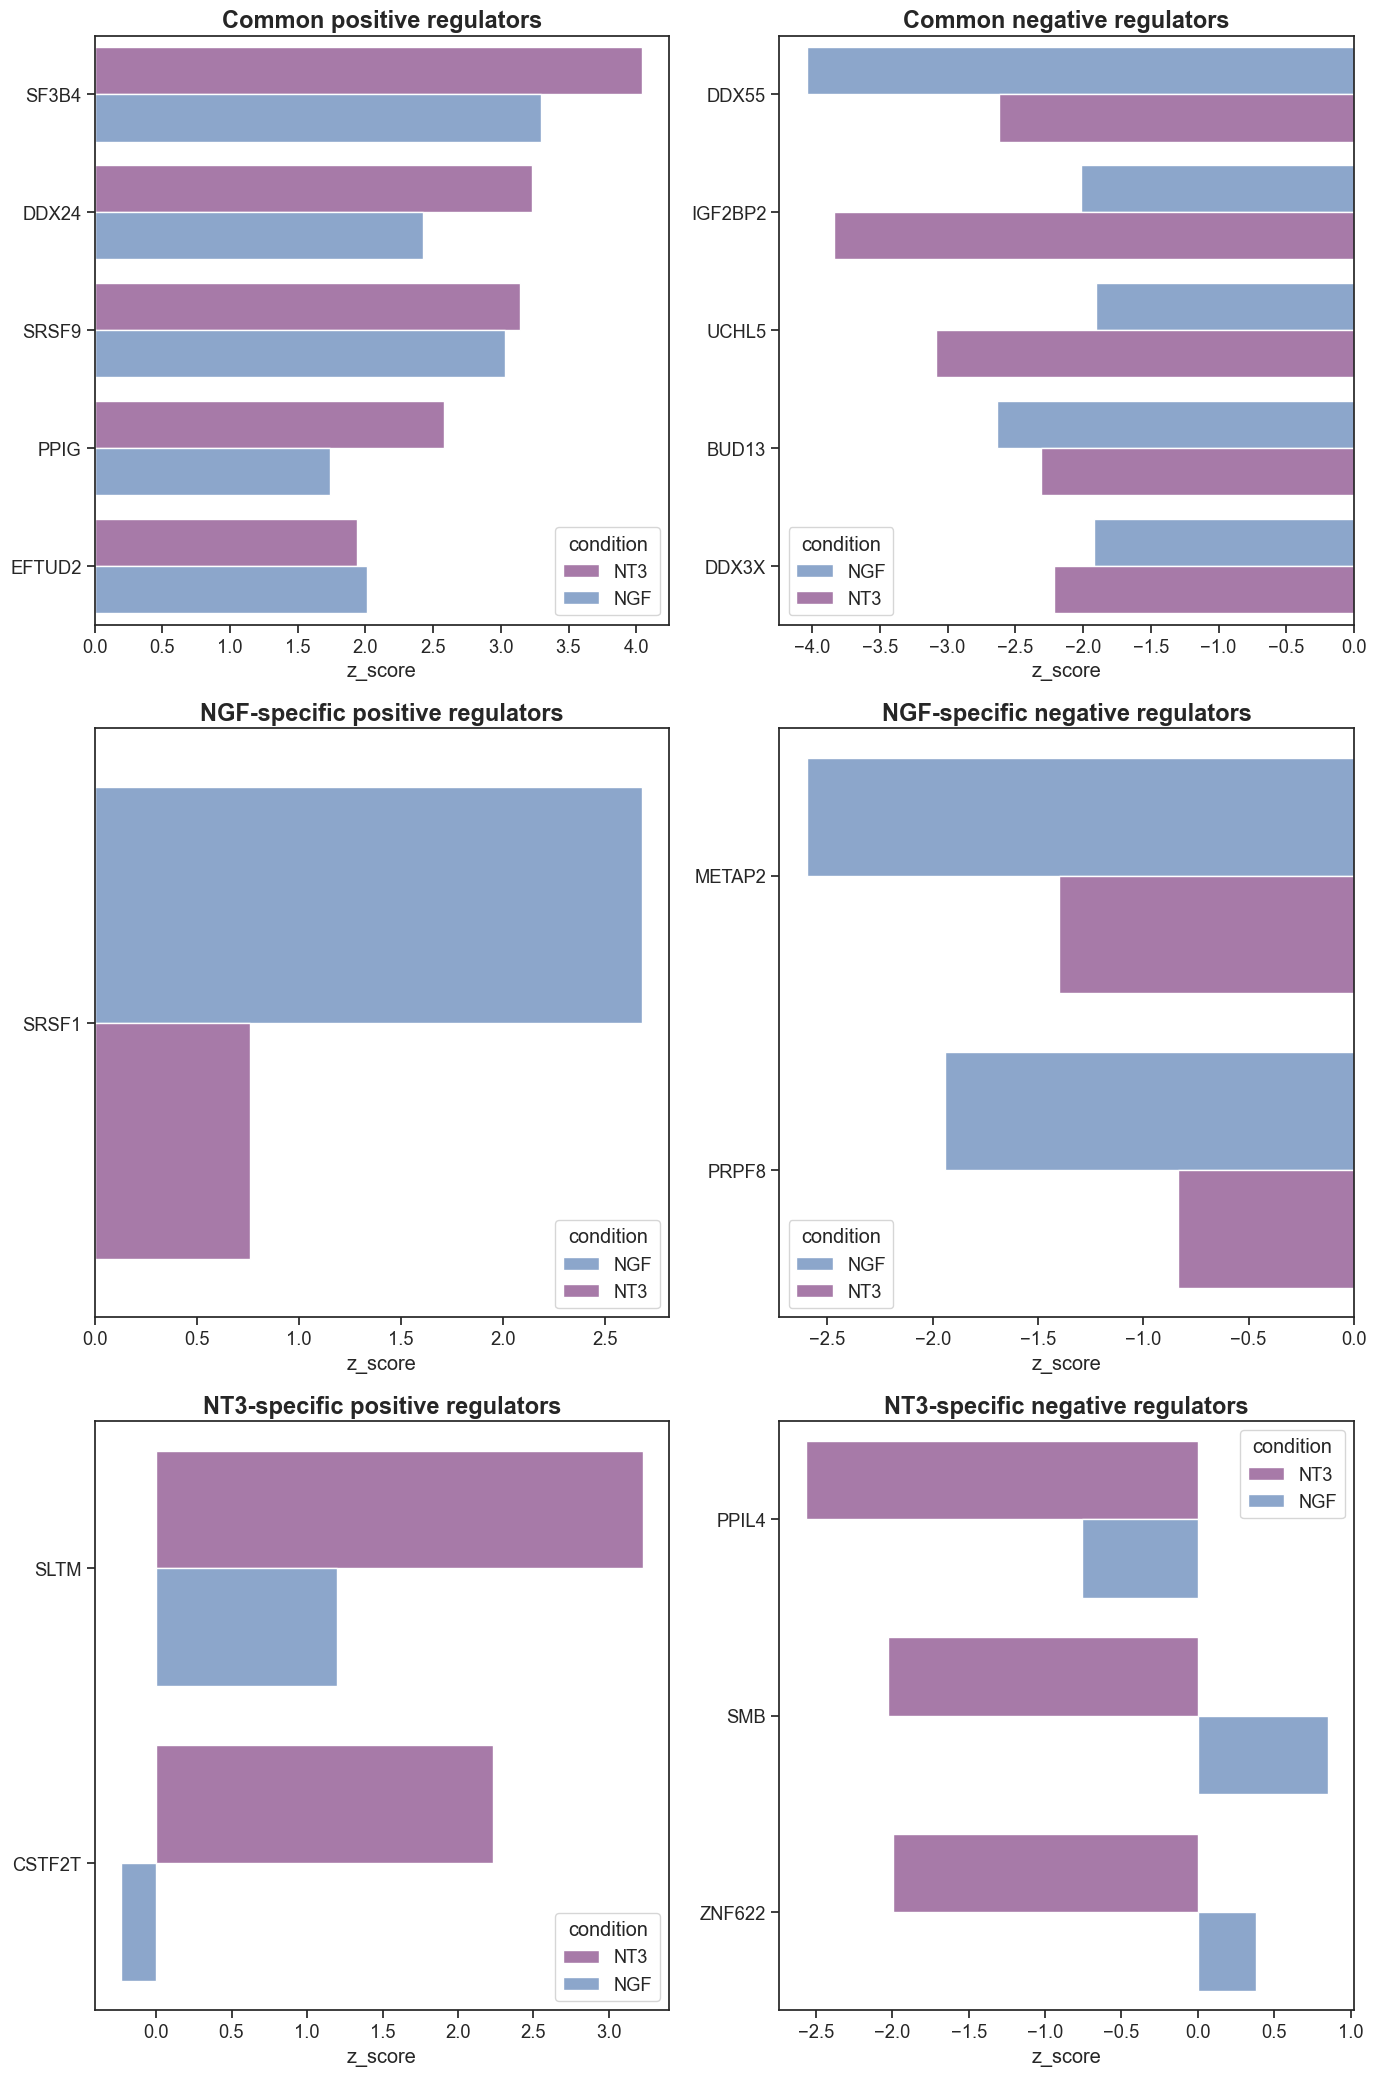

In [15]:
plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset_positive',
                                         model_key='logit_model_positive',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions)

## 6. Model 3: The 11 RBPs negative regulators of localization (M3)

Here, we train a logistic regression classifier to discriminate over- from under-transported 3’ UTR isoforms using the 11 candidate negative regulators of axonal localisation only. We report the classification results and the coefficients of the logistic regression. To identify the statistically significant predictors in each model (RBPs or interaction of RBPs) in each culture condition, we compared the observed predictor coefficients to their respective null distributions, as described in   [section 4](#4-model-1-all-44-rbps-m1).

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       277
           1       0.61      0.55      0.58       265

    accuracy                           0.61       542
   macro avg       0.61      0.61      0.61       542
weighted avg       0.61      0.61      0.61       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       256
           1       0.67      0.56      0.61       287

    accuracy                           0.62       543
   macro avg       0.63      0.62      0.62       543
weighted avg       0.63      0.62      0.62       543



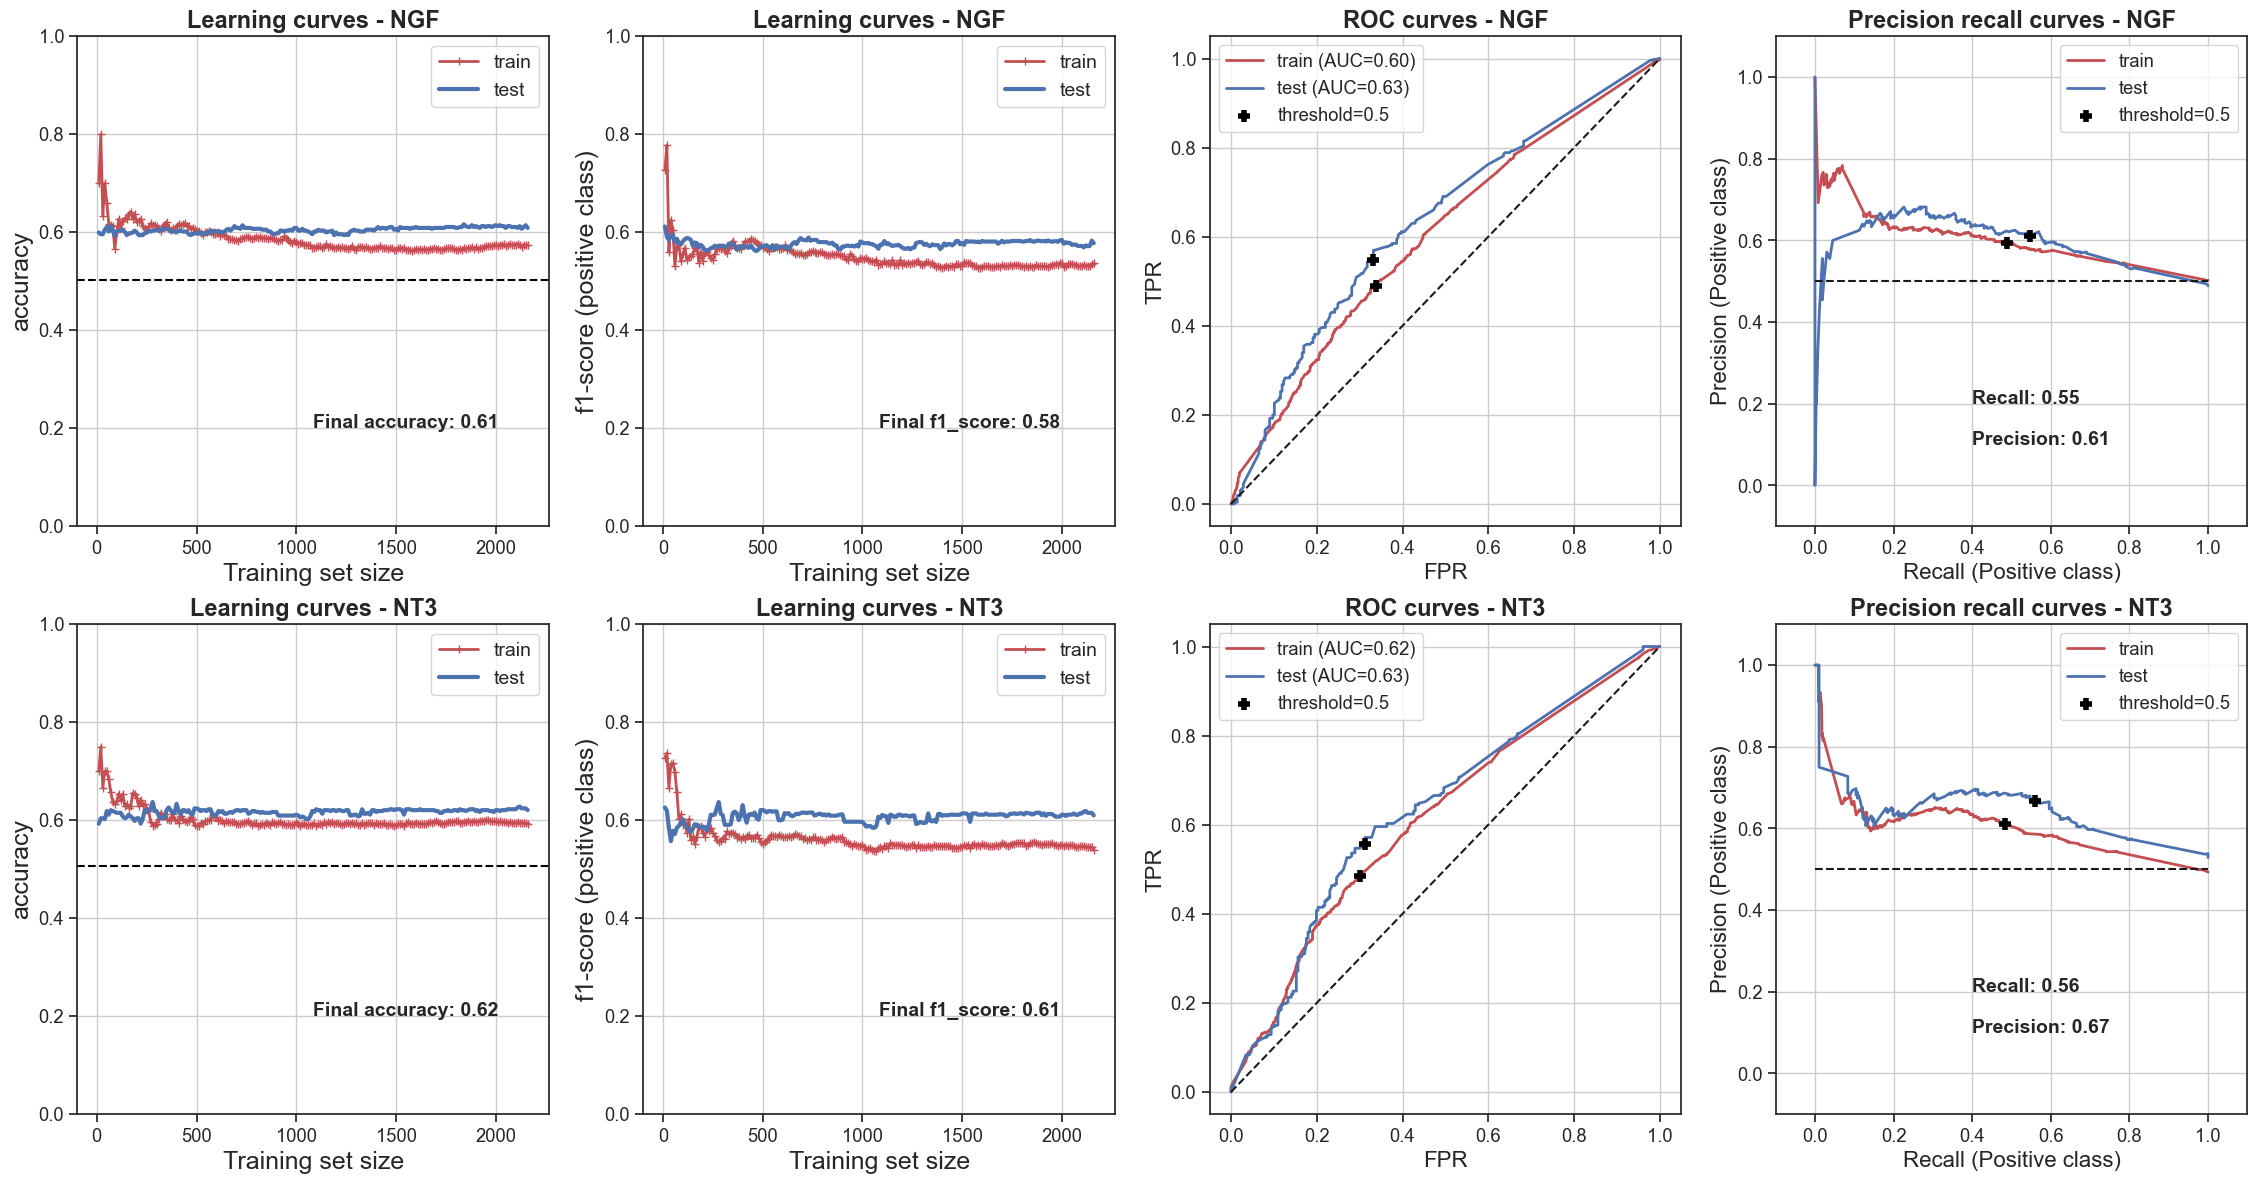

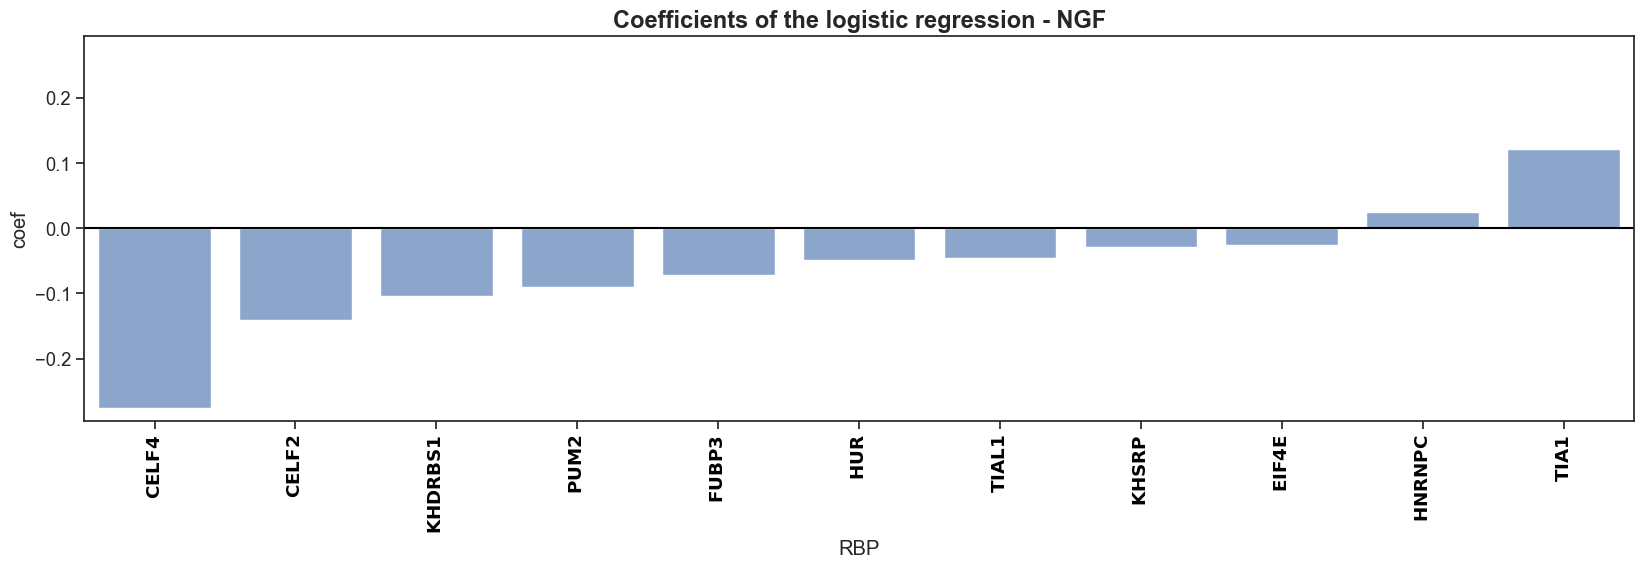

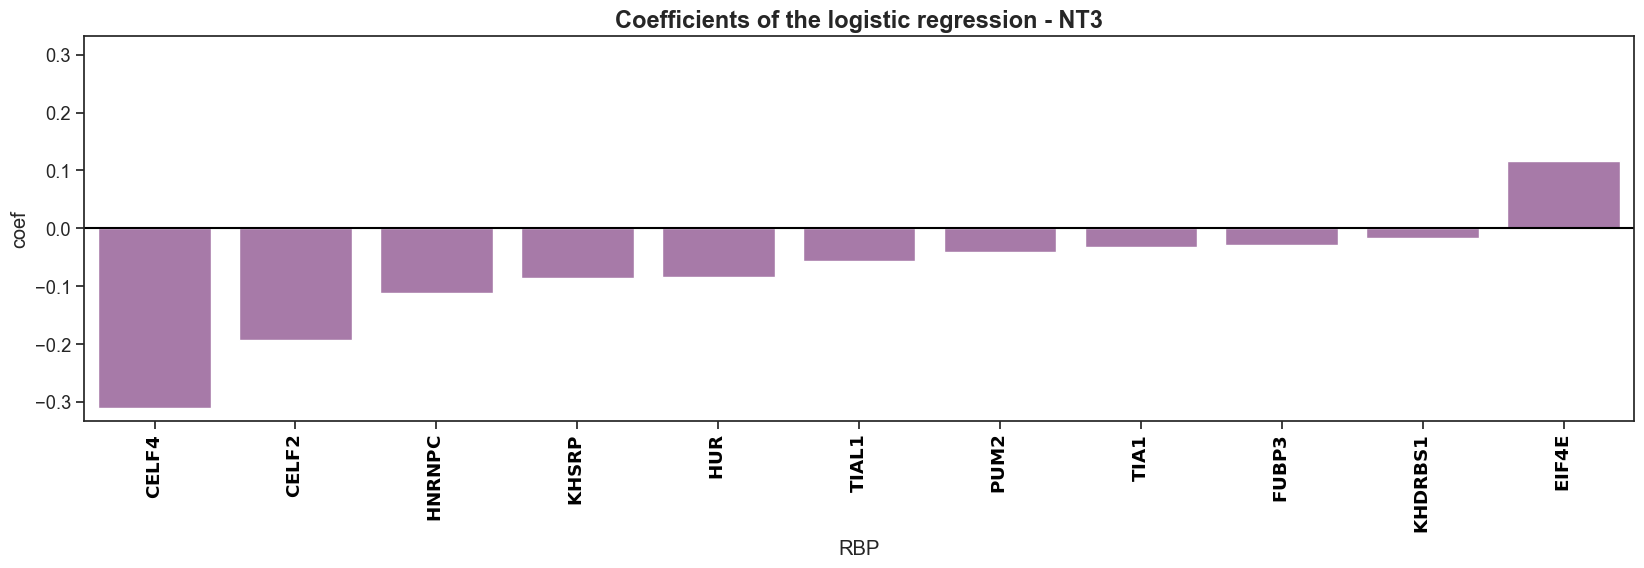

In [16]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset_negative',
                              suffix='_negative',
                              include_plots=True,
                              conditions_names=conditions_names, 
                              palette=palette,
                              step_learning=10,
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators,                               
                              parameters_lr=parameters_lr)

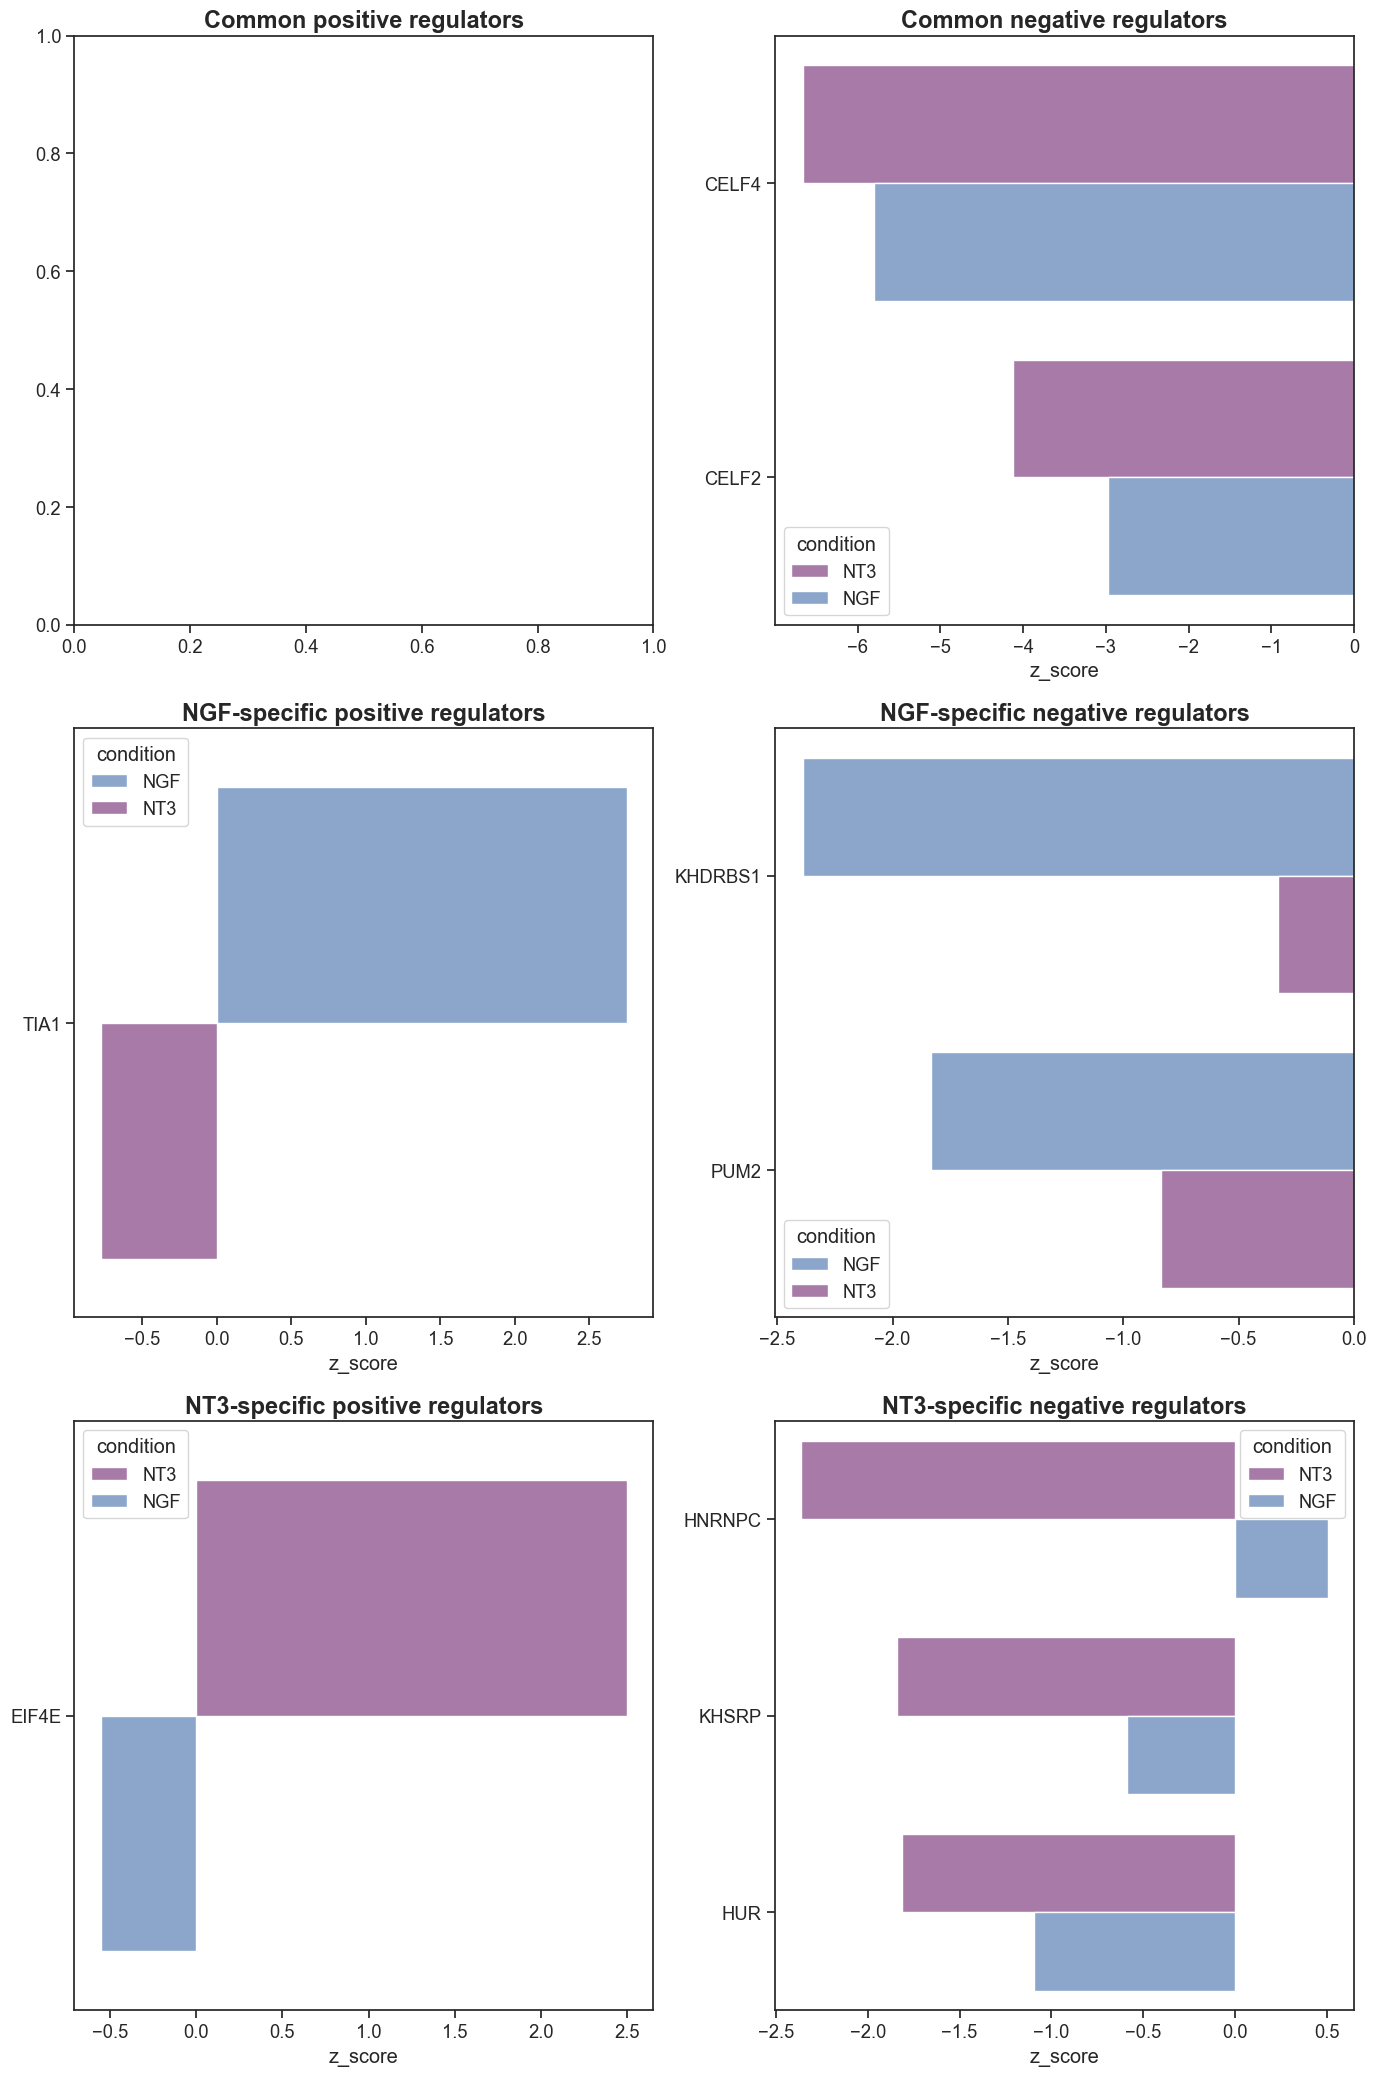

In [17]:
plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset_negative',
                                         model_key='logit_model_negative',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions)

## 7. Model 4: The top 42 interactions between RBPs (M4)

### 7.1 Select the top 4 positive and negative RBPs candidate regulators in each condition

Due to computational and dataset size limitations, not all possible interaction terms can be added into the models. Therefore, for each condition, the top four most important features contributing positively to the model without interactions (positive regulators) and the top four most important features contributing negatively to the model without interactions (negative regulators).

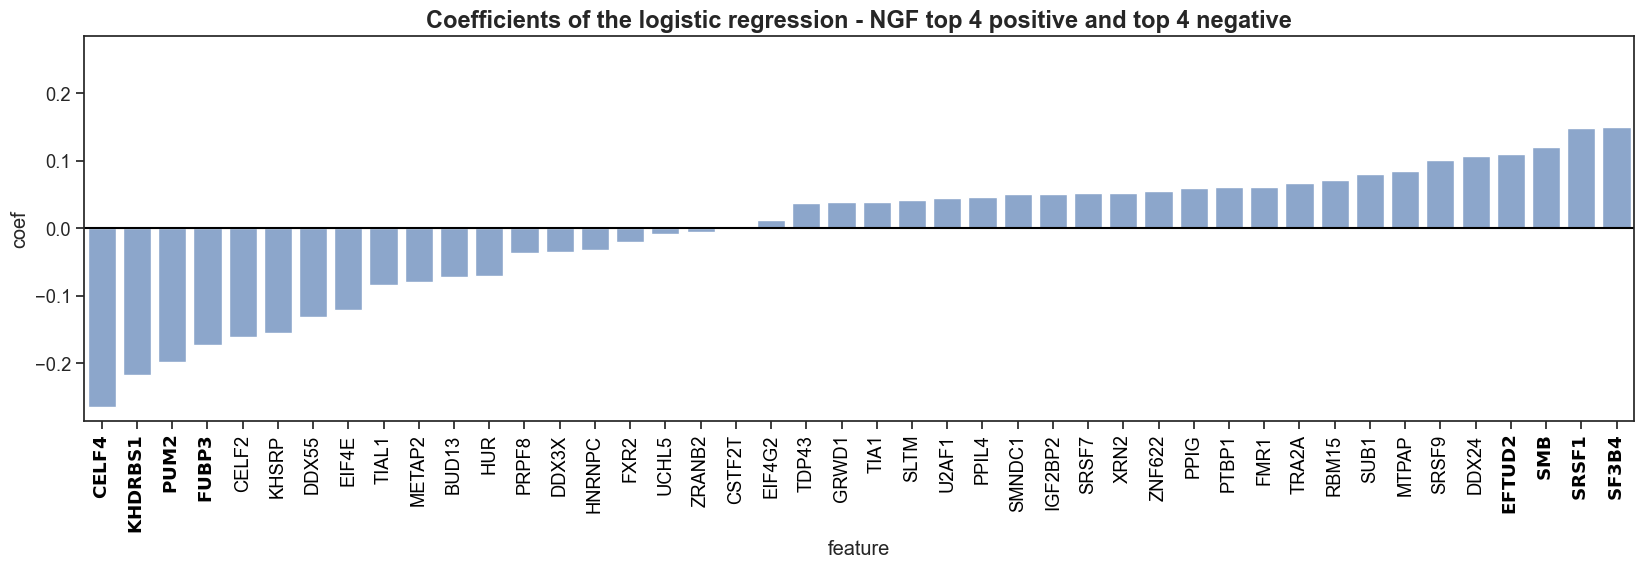

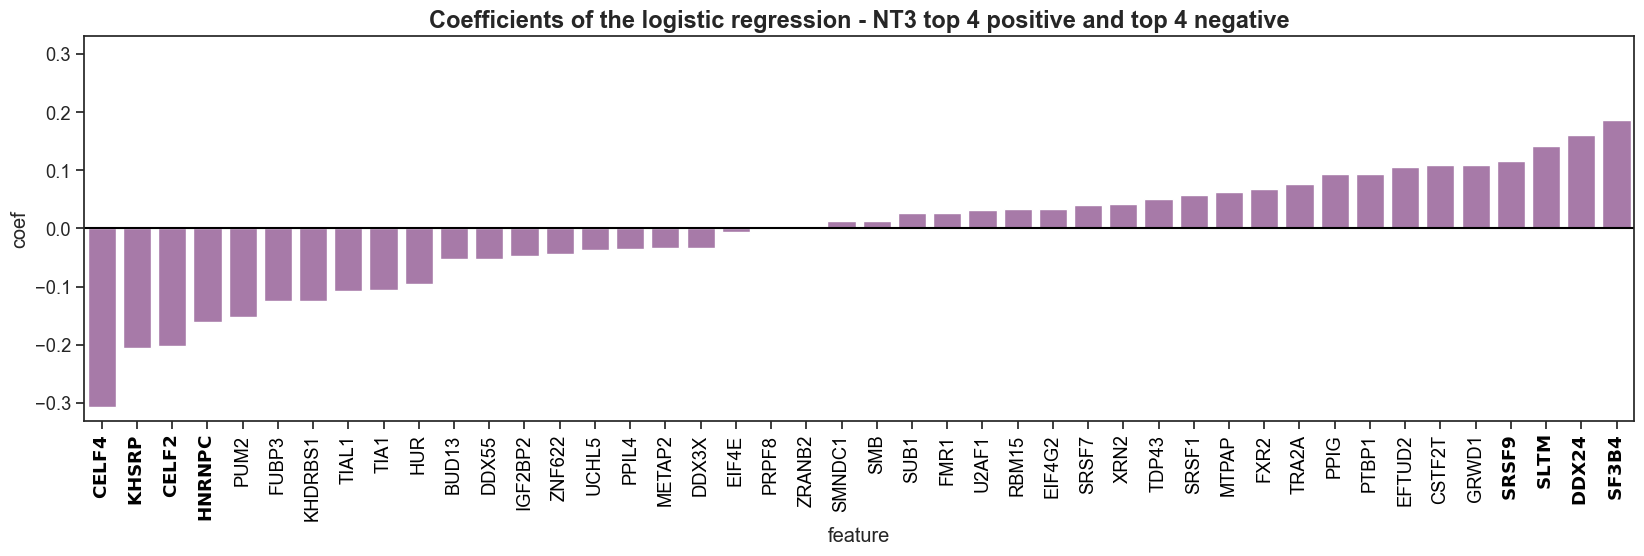

In [9]:
# for materials and methods 

nb_top = 4

for i, condition in enumerate(datasets_per_condition.keys()):
    top_features = list(datasets_per_condition[condition]['logit_coef'].sort_values('coef')[:nb_top].index)+list(datasets_per_condition[condition]['logit_coef'].sort_values('coef')[-nb_top:].index)
    plot_coefficients_from_logistic_model(datasets_per_condition[condition]['logit_model'], 
                            color=palette[condition], 
                            negative_regulators=top_features,
                            condition_name = conditions_names[i]+" top 4 positive and top 4 negative",
                            features_names=datasets_per_condition[condition]['dataset']['X_train'].columns)

## 7.2 Create pairwise interaction terms

From the unique positive regulators identified above (namely EFTUD2, SMB, SRSF1, SF3B4, SRSF9, STLM and DDX24); we create unique pairwise interaction terms. We do the same for the identified negative regulators (CELF4, KHDRBS1, PUM2, FUBP3, KHSRP, CELF2 and HNRNPC).

In [10]:
# top features to create interction terms
nb_top = 4


## Add interactions between top 4 positive and top 4 negative features of each condition
top_features_pos = []
top_features_neg = []

for condition in datasets_per_condition.keys():
    coeff = datasets_per_condition[condition]['logit_coef'].reset_index().rename(columns={'index': 'RBP'}).sort_values('coef')
    top_features_pos += list(coeff.reindex(coeff.coef.sort_values(ascending=False).index).head(nb_top)['RBP'])
    top_features_neg += list(coeff.reindex(coeff.coef.sort_values(ascending=True).index).head(nb_top)['RBP'])
    
top_features_pos = list(set(top_features_pos))
top_features_neg = list(set(top_features_neg))
combs = list(combinations(list(top_features_neg), 2))  + list(combinations(list(top_features_pos), 2))
combs = list(set(list(combs)))
combs = list(set(tuple(sorted(comb)) for comb in combs))
print("Here is the list of the", len(combs), "pairwise interactions created:", combs)

Here is the list of the 42 pairwise interactions created: [('SLTM', 'SMB'), ('HNRNPC', 'KHSRP'), ('EFTUD2', 'SRSF9'), ('KHDRBS1', 'KHSRP'), ('DDX24', 'SRSF9'), ('EFTUD2', 'SRSF1'), ('CELF4', 'PUM2'), ('DDX24', 'SRSF1'), ('CELF2', 'KHDRBS1'), ('FUBP3', 'KHSRP'), ('DDX24', 'SLTM'), ('CELF4', 'HNRNPC'), ('EFTUD2', 'SLTM'), ('CELF2', 'FUBP3'), ('SF3B4', 'SRSF9'), ('CELF2', 'CELF4'), ('SF3B4', 'SRSF1'), ('EFTUD2', 'SMB'), ('CELF2', 'KHSRP'), ('DDX24', 'SMB'), ('HNRNPC', 'PUM2'), ('KHSRP', 'PUM2'), ('KHDRBS1', 'PUM2'), ('SMB', 'SRSF9'), ('SMB', 'SRSF1'), ('SF3B4', 'SLTM'), ('DDX24', 'EFTUD2'), ('SRSF1', 'SRSF9'), ('FUBP3', 'PUM2'), ('SF3B4', 'SMB'), ('EFTUD2', 'SF3B4'), ('DDX24', 'SF3B4'), ('CELF4', 'KHDRBS1'), ('CELF2', 'PUM2'), ('FUBP3', 'HNRNPC'), ('CELF4', 'FUBP3'), ('SLTM', 'SRSF9'), ('CELF2', 'HNRNPC'), ('SLTM', 'SRSF1'), ('CELF4', 'KHSRP'), ('HNRNPC', 'KHDRBS1'), ('FUBP3', 'KHDRBS1')]


### 7.3 Train the logistic regression classifier with the interaction terms only

In [11]:
for condition in datasets_per_condition.keys():
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()

    X_train_int, X_test_int, y_train_int, y_test_int = create_interaction_dataset_from_list(X_train, 
                                                                                            X_test,
                                                                                            y_train,
                                                                                            y_test,
                                                                                            list_interactions=combs,
                                                                                            keep_old=False)

    datasets_per_condition[condition]['dataset_with_interactions'] = {'X_train': X_train_int, 
                                                                    'X_test': X_test_int, 
                                                                    'y_train': y_train_int, 
                                                                    'y_test': y_test_int}


Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       277
           1       0.60      0.71      0.65       265

    accuracy                           0.63       542
   macro avg       0.63      0.63      0.63       542
weighted avg       0.63      0.63      0.63       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       256
           1       0.64      0.70      0.67       287

    accuracy                           0.64       543
   macro avg       0.64      0.63      0.63       543
weighted avg       0.64      0.64      0.64       543



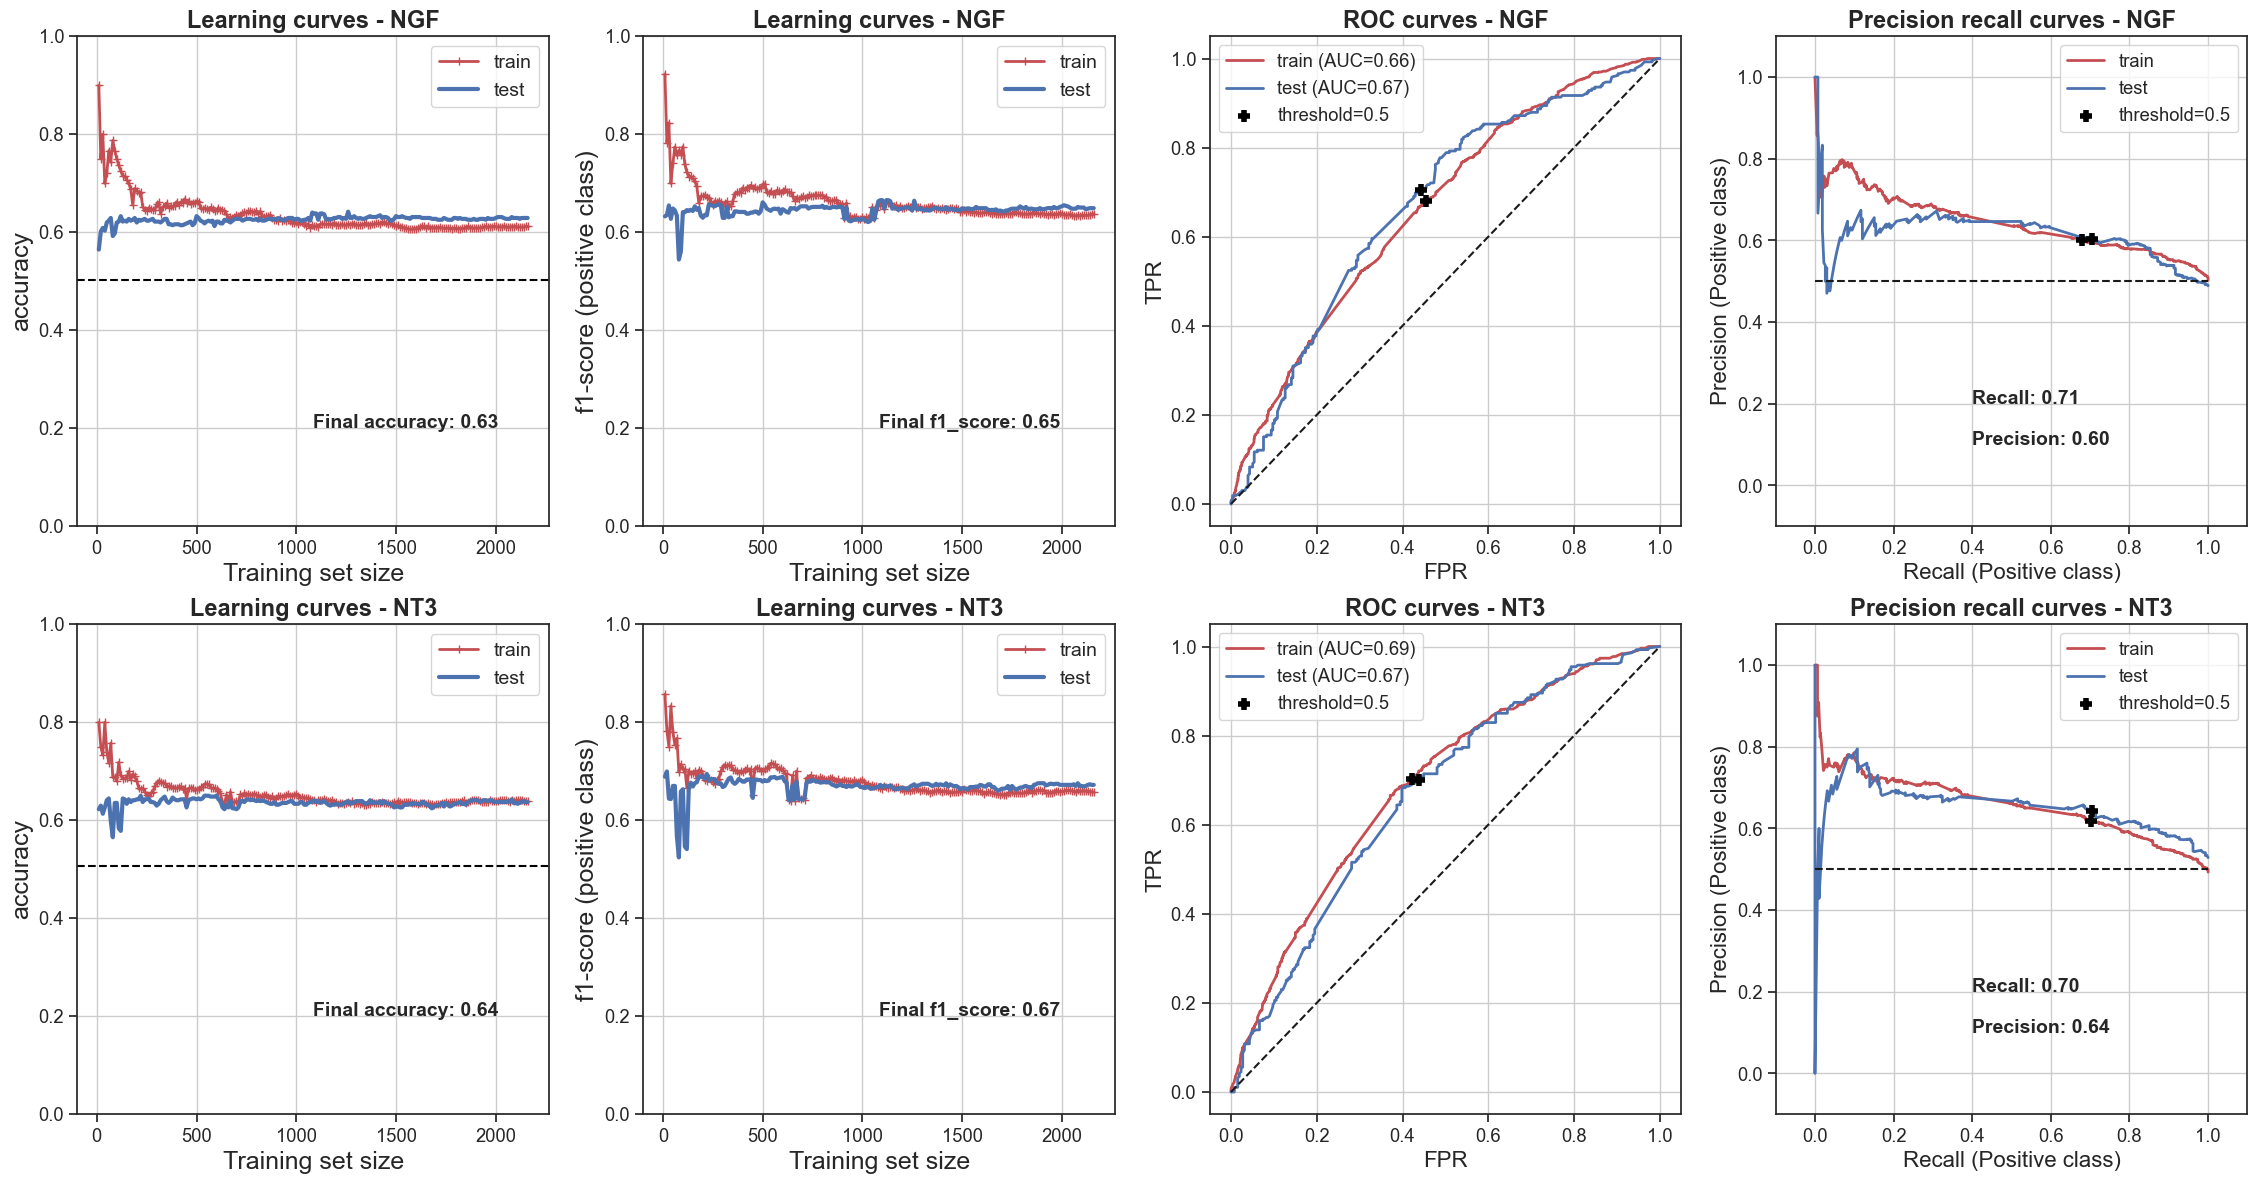

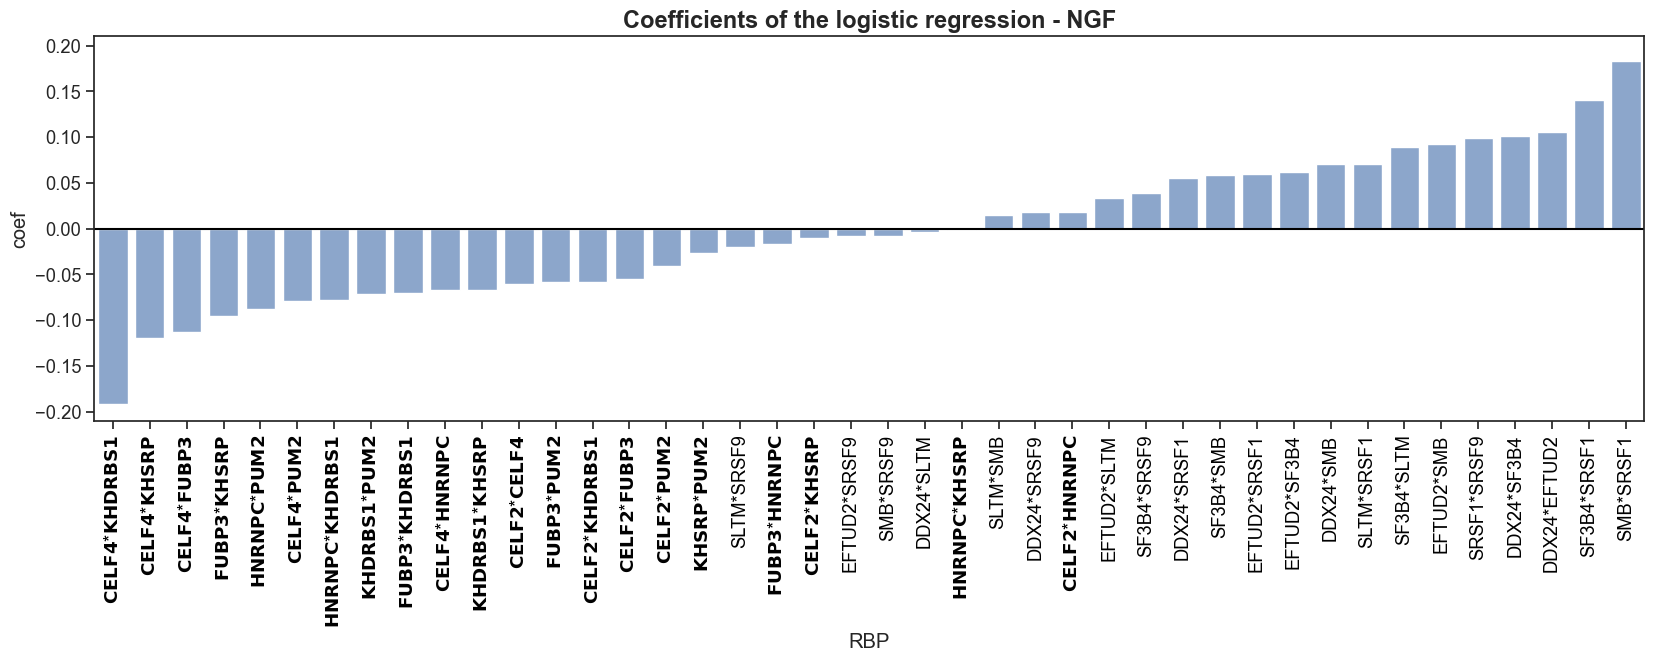

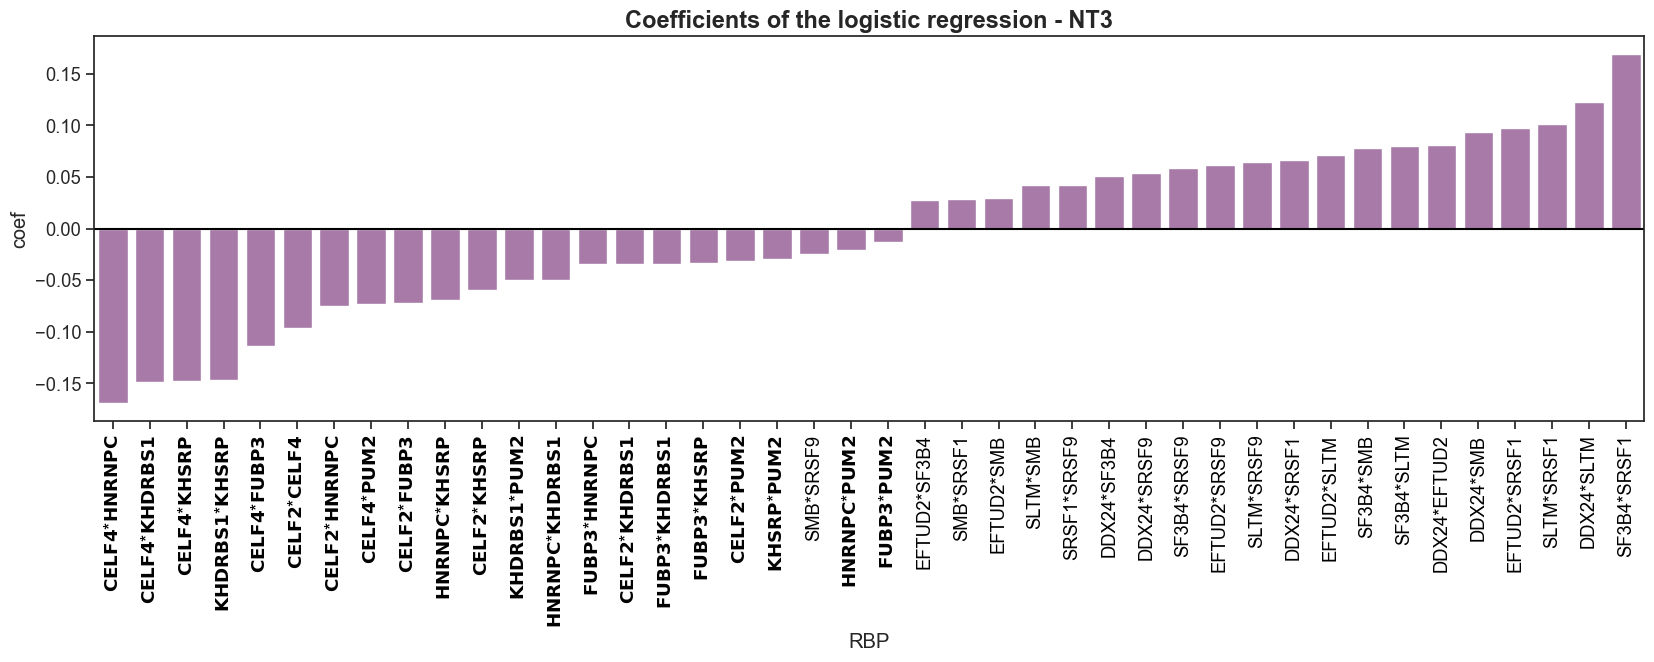

In [12]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition, 
                              dataset_key='dataset_with_interactions', 
                              suffix='_interactions', include_plots=True,
                              conditions_names=['NGF', 'NT3'],
                              palette=palette,
                              step_learning=10, 
                              threshold=0.5,
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators,                               
                              parameters_lr=parameters_lr)

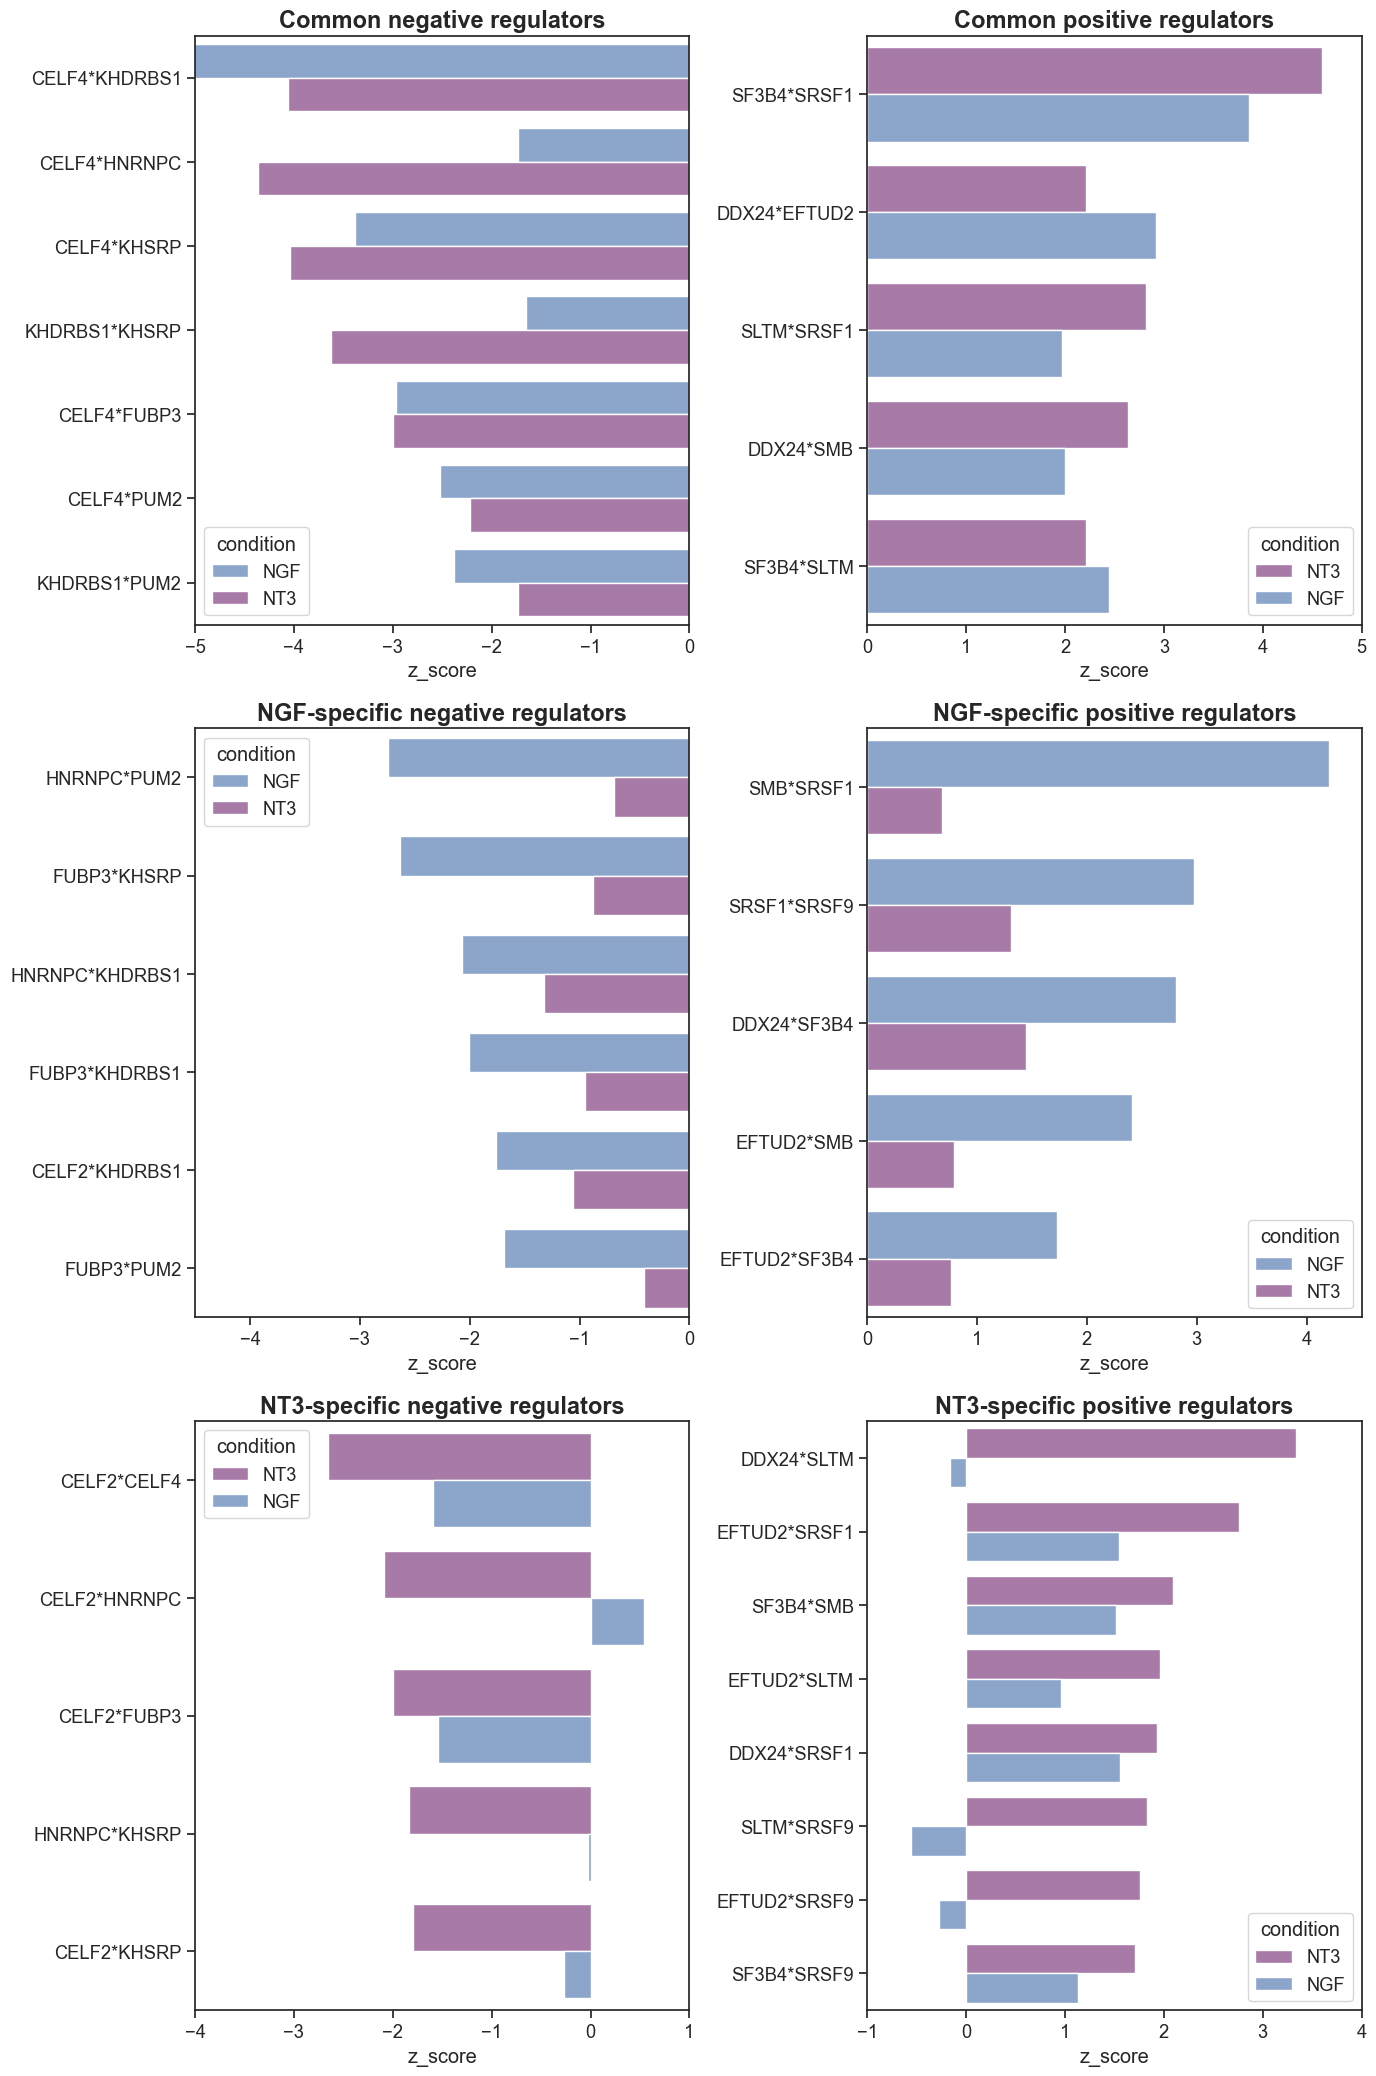

In [14]:
dic_summary = plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset_with_interactions',
                                         model_key='logit_model_interactions',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions, 
                                         save_path='./Results', 
                                         format='pdf', 
                                         return_groups=True)

In [106]:
## Identify some targets to look at in IGV

df_merged = []
for condition in datasets_per_condition.keys():
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset_with_interactions'].values()

    X_train_cc = X_train.copy()
    X_train_cc['y_true'] = y_train
    X_test_cc = X_test.copy()
    X_test_cc['y_true'] = y_test
    df_merged.append(pd.concat([X_train_cc, X_test_cc]))

### over transported in both & having all common positive interactions
df_both = df_merged[0].merge(df_merged[1][['y_true']], left_index=True, right_index=True, suffixes=('_ngf', '_nt3'))
common_positive_targets = df_both[(df_both['y_true_ngf'] == 1) & (df_both['y_true_nt3'] == 1)]
common_positive_targets[common_positive_targets[dic_summary["Positive common"].index].sum(axis=1) == len(dic_summary["Positive common"])].to_csv("./Results/over_transported_in_both_all_common_positive_interactions.csv")


### under transported in both & having all common negative interactions
common_negative_targets = df_both[(df_both['y_true_ngf'] == 0) & (df_both['y_true_nt3'] == 0)]
common_negative_targets[common_negative_targets[dic_summary["Negative common"].index].sum(axis=1) == len(dic_summary["Negative common"])].to_csv("./Results/under_transported_in_both_all_common_negative_interactions.csv")

## NGF-specific negative regulators & having all NGF-specific negative interactions
df_both_outer =  df_merged[0].merge(df_merged[1][['y_true']], left_index=True, right_index=True, suffixes=('_ngf', '_nt3'), how='outer')
ngf_specific_targets = df_both_outer[(df_both_outer['y_true_ngf'] == 0) & (df_both_outer['y_true_nt3'] != 0)]
ngf_specific_targets[ngf_specific_targets[dic_summary["Negative NGF-specific"].index].sum(axis = 1) == len(dic_summary["Negative NGF-specific"])].to_csv("./Results/under_transported_in_NGF_all_NGF_negative_interactions.csv")

## NGF-specific positive regulators & having all NGF-specific positive interactions
ngf_specific_targets = df_both_outer[(df_both_outer['y_true_ngf'] == 1) & (df_both_outer['y_true_nt3'] != 1)]
ngf_specific_targets[ngf_specific_targets[dic_summary["Positive NGF-specific"].index].sum(axis = 1) == len(dic_summary["Positive NGF-specific"])].to_csv("./Results/over_transported_in_NGF_all_NGF_positive_interactions.csv")

## NT3-specific negative regulators & having all NT3-specific negative interactions
df_both_outer =  df_merged[1].merge(df_merged[0][['y_true']], left_index=True, right_index=True, suffixes=('_nt3', '_ngf'), how='outer')
ngf_specific_targets = df_both_outer[(df_both_outer['y_true_nt3'] == 0) & (df_both_outer['y_true_ngf'] != 0)]
ngf_specific_targets[ngf_specific_targets[dic_summary["Negative NT3-specific"].index].sum(axis = 1) == len(dic_summary["Negative NT3-specific"])].to_csv("./Results/under_transported_in_NT3_all_NT3_negative_interactions.csv")

## NT3-specific positive regulators & having all NT3-specific positive interactions
ngf_specific_targets = df_both_outer[(df_both_outer['y_true_nt3'] == 1) & (df_both_outer['y_true_ngf'] != 1)]
ngf_specific_targets[ngf_specific_targets[dic_summary["Positive NT3-specific"].index].sum(axis = 1) == len(dic_summary["Positive NT3-specific"])].to_csv("./Results/over_transported_in_NT3_all_NT3_positive_interactions.csv")

100%|██████████| 5/5 [01:41<00:00, 20.31s/it]


100%|██████████| 5/5 [01:27<00:00, 17.51s/it]


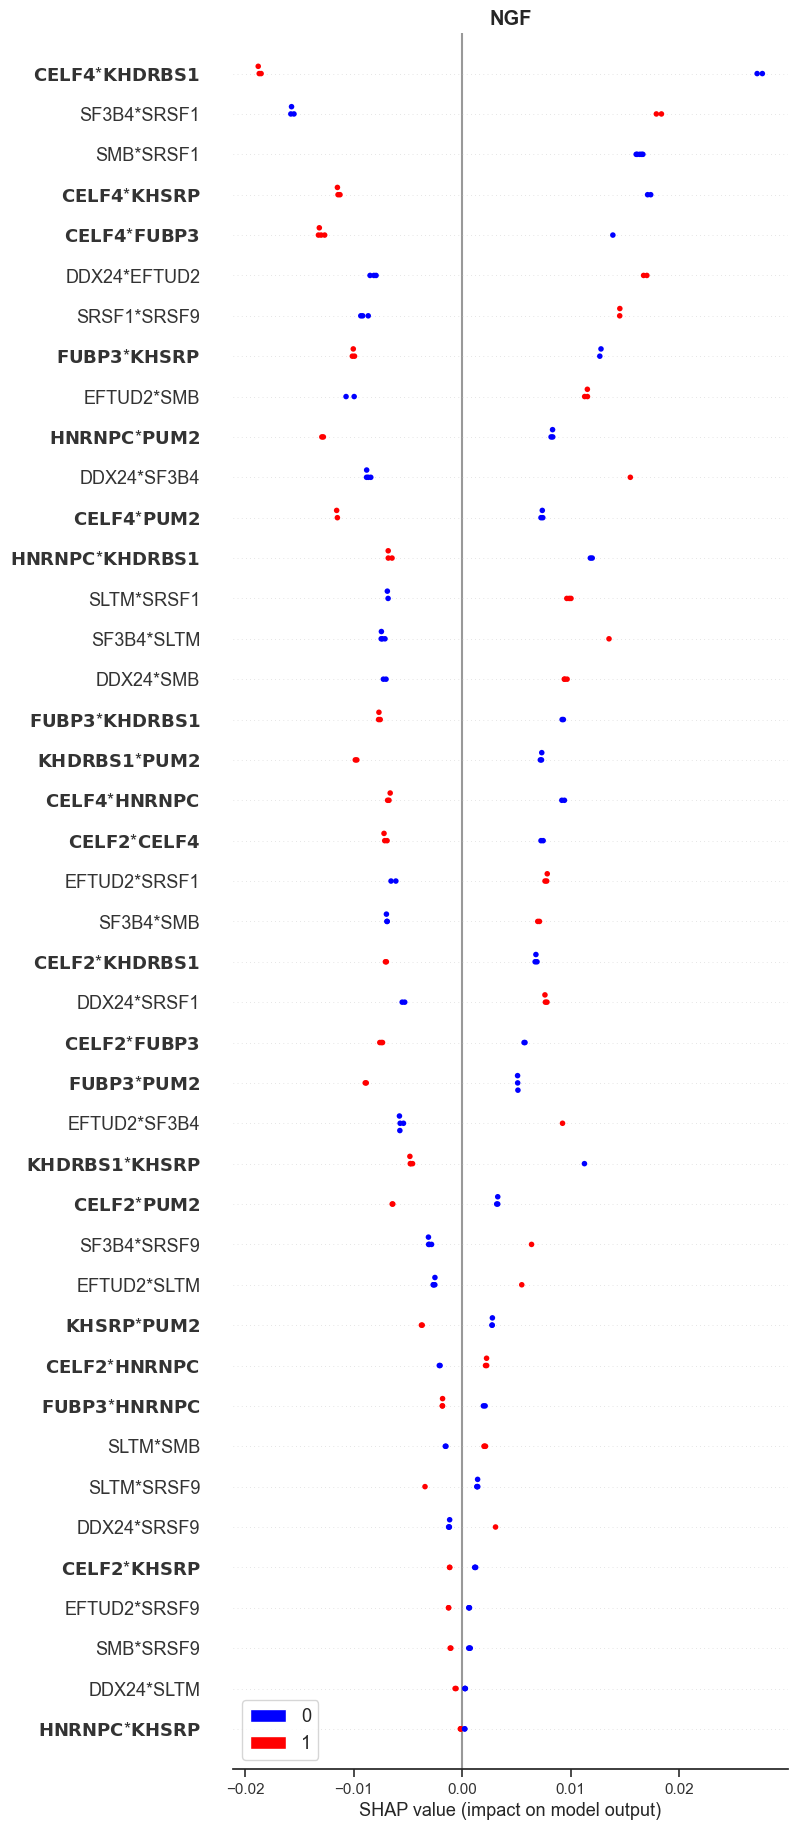

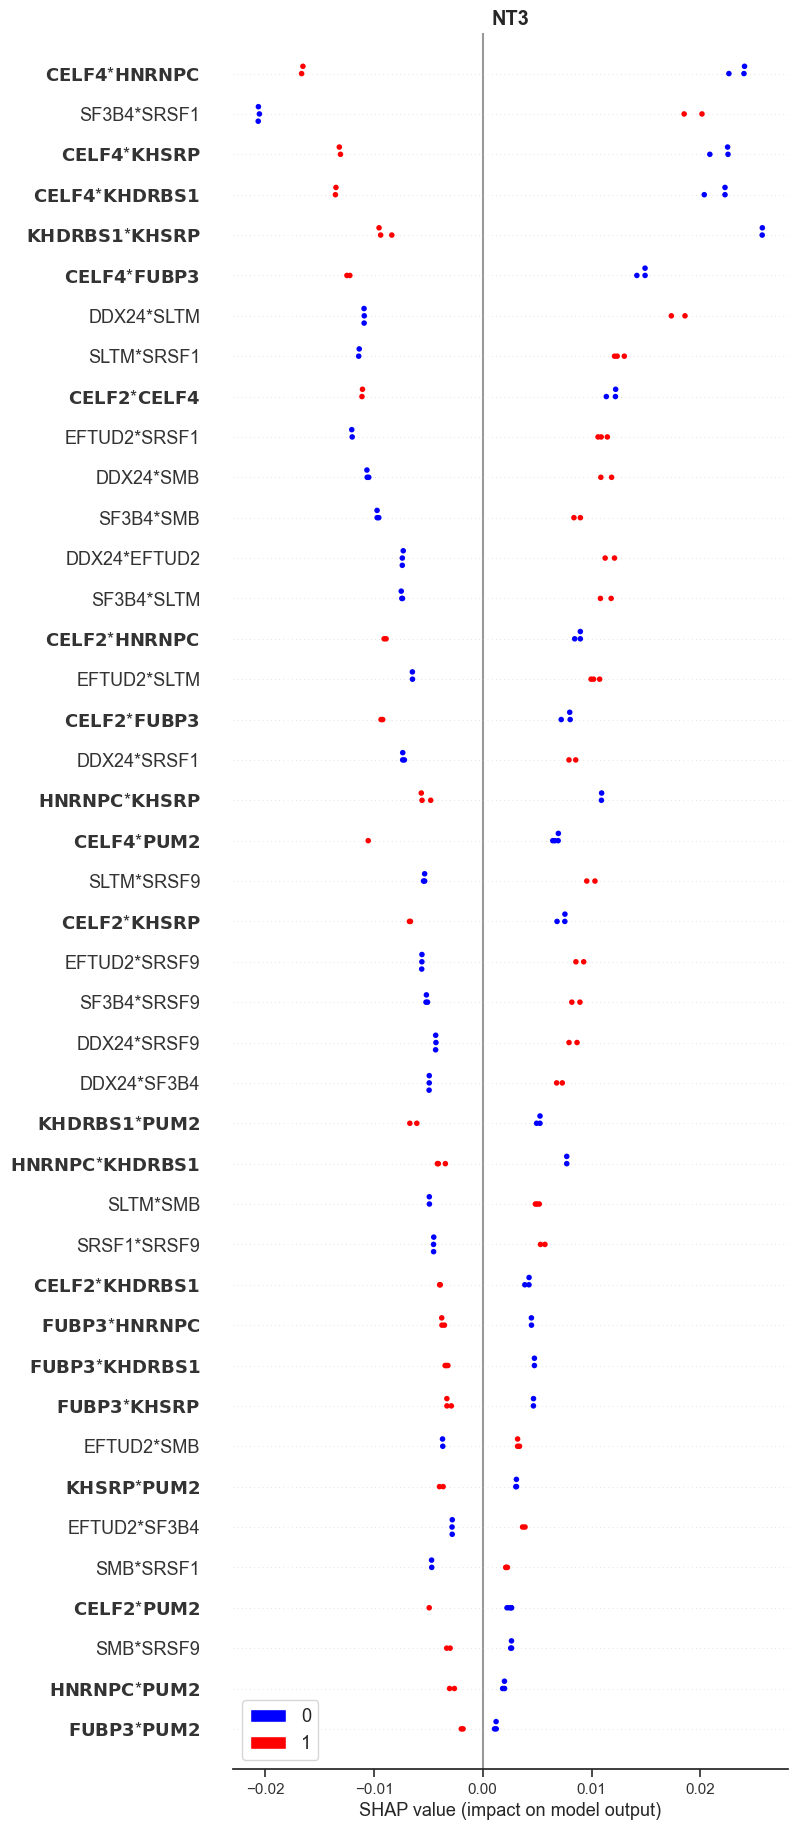

In [24]:
for i, condition in enumerate(datasets_per_condition.keys()):
    model = datasets_per_condition[condition]['logit_model_interactions']
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset_with_interactions'].values()
    feature_names = datasets_per_condition[condition]['dataset_with_interactions']['X_train'].columns

    shap.initjs()
    
    # Initialize the explainer
    explainer = KernelExplainer(model.predict_proba, X_train, n_jobs=4)
    
    # Compute the shapley values
    shap_values = explainer.shap_values(X_test[:nb_shapley])
    
    plot_shapley(shap_values=shap_values, 
                 X_test=X_test[:nb_shapley], 
                 feature_names=feature_names, 
                 max_display=X_test.shape[1], 
                 show=False,
                 class_label=1,
                 negative_regulators=negative_regulators, 
                 condition_name=conditions_names[i], 
                 beeswarm_only=True)

## 8. Model comparison (M1, M2, M3 & M4)

Text(0.5, 0.98, 'Classification scores of the logistic regression models the different feature sets')

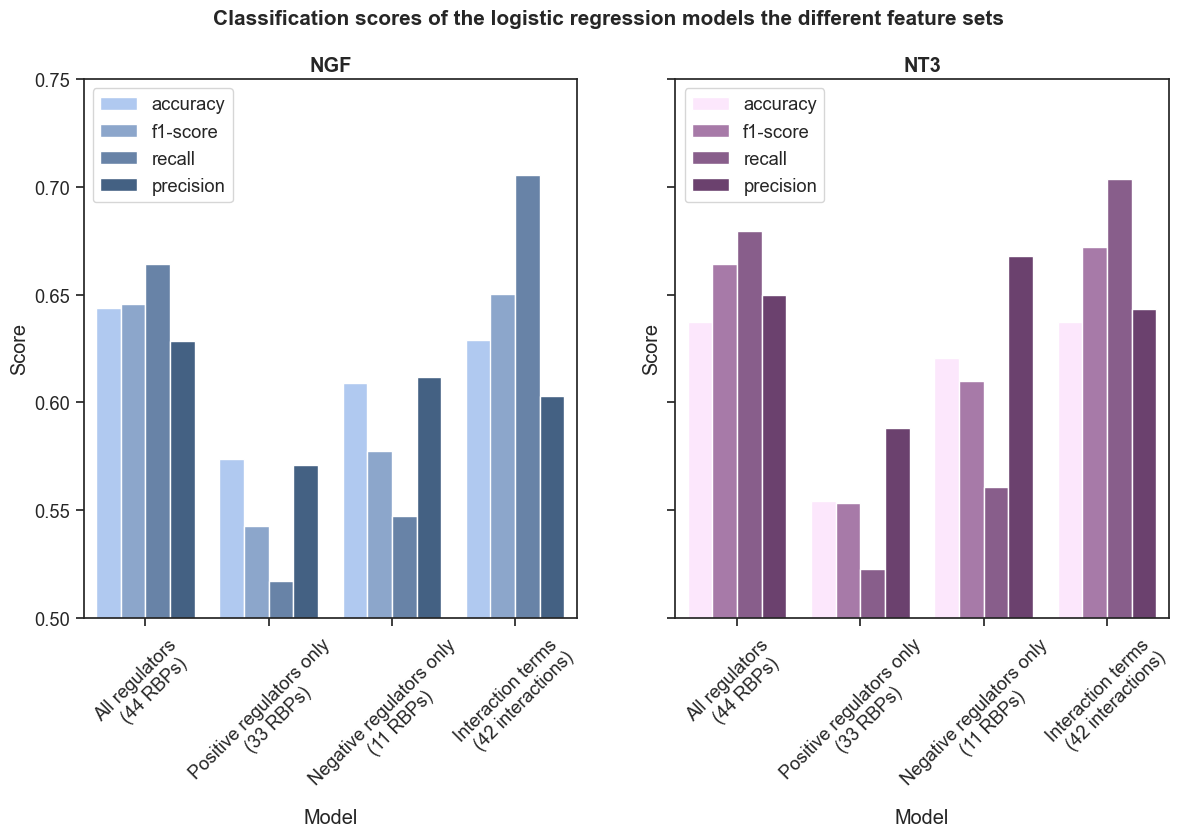

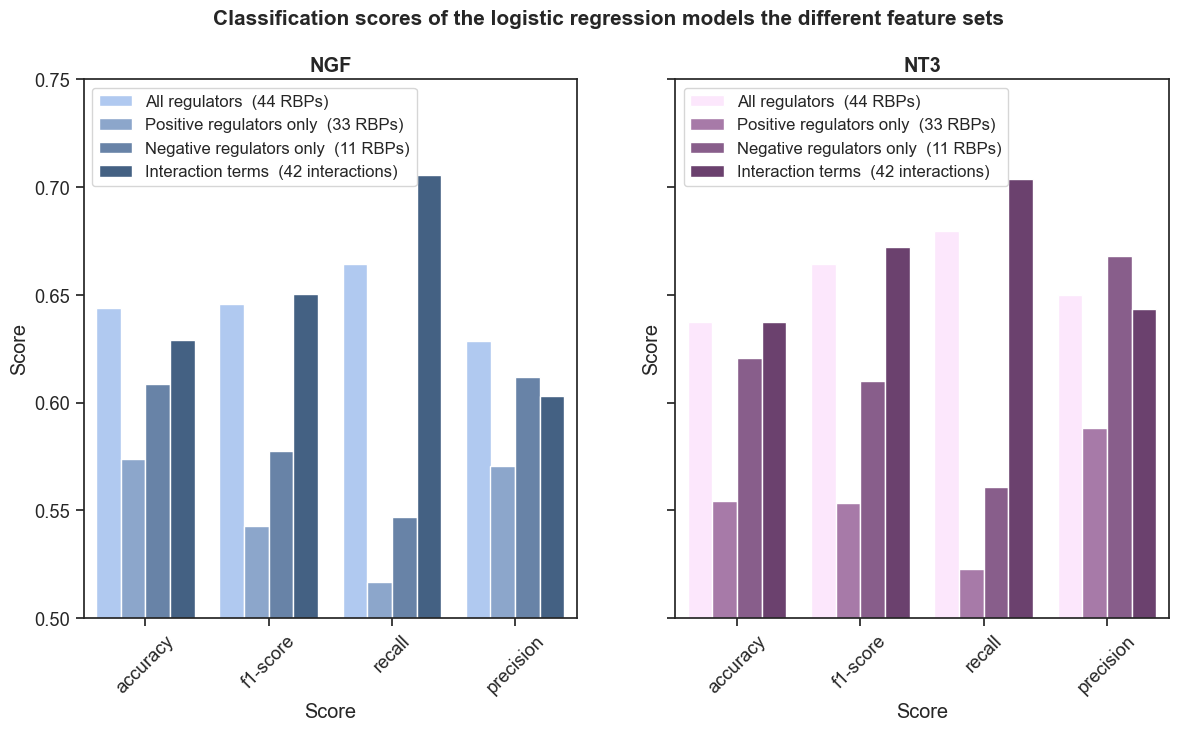

In [23]:
## Plot summarizing the metrics
dfs_summary = {}
for condition in datasets_per_condition.keys():
    
    dfs_summary[condition] = {}
    
    for dataset, model, name in zip(['dataset', 'dataset_positive', 'dataset_negative', 'dataset_with_interactions'],
                                    ['logit_model', 'logit_model_positive', 'logit_model_negative', 'logit_model_interactions'], 
                                    ['All regulators \n (44 RBPs)', 'Positive regulators only \n (33 RBPs)', 
                                     'Negative regulators only \n (11 RBPs)', "Interaction terms \n (42 interactions)"]):
    
        X_train, X_test, y_train, y_test = datasets_per_condition[condition][dataset].values()

        # Logistic regression 
        y_pred = datasets_per_condition[condition][model].predict(X_test)
        
        report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        f1_score = report['1']['f1-score']
        recall = report['1']['recall']
        precision = report['1']['precision']
        dfs_summary[condition][name] = {'accuracy': accuracy, 
                                        'f1-score': f1_score, 
                                        'recall': recall, 
                                        'precision': precision}

fig, ax = plt.subplots(1, len(dfs_summary.keys()), figsize=(7*len(dfs_summary.keys()), 7), sharey=True)

for i, condition in enumerate(dfs_summary.keys()):
    df = pd.DataFrame(dfs_summary[condition])
    scores = list(df.index)
    df_plot = pd.melt(df, var_name='Model')
    df_plot['Score'] = scores*df.shape[1]
    
    sns.barplot(df_plot, x='Model', y='value', hue='Score', ax=ax[i], palette=continuous_palette[i])
    ax[i].legend(loc='upper left')
    ax[i].set_title(conditions_names[i], weight='bold')
    ax[i].set_xticks(ticks=np.arange(len(dfs_summary[condition].keys())), 
                     labels=dfs_summary[condition].keys(),
                     rotation=45)
    ax[i].set_ylabel("Score")
    ax[i].set_ylim(0.5, 0.75)
plt.suptitle("Classification scores of the logistic regression models the different feature sets", weight='bold', fontsize=15)


fig, ax = plt.subplots(1, len(dfs_summary.keys()), figsize=(7*len(dfs_summary.keys()), 7), sharey=True)

for i, condition in enumerate(dfs_summary.keys()):
    df = pd.DataFrame(dfs_summary[condition])
    scores = list(df.index)
    df_plot = pd.melt(df, var_name='Model')
    df_plot['Score'] = scores*df.shape[1]
    df_plot['Model'] = df_plot["Model"].apply(lambda x: "".join(x.split("\n")))
    
    sns.barplot(df_plot, x='Score', y='value', hue='Model', ax=ax[i], palette=continuous_palette[i])
    ax[i].legend(loc='upper left', fontsize=12)
    ax[i].set_title(conditions_names[i], weight='bold')
    ax[i].set_xticks(ticks=np.arange(len(scores)), 
                     labels=scores,
                     rotation=45)
    ax[i].set_ylabel("Score")
    ax[i].set_ylim(0.5, 0.75)
plt.suptitle("Classification scores of the logistic regression models the different feature sets", weight='bold', fontsize=15)
